<h2>Initialize all imports</h2>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import time
import gc
from pathlib import Path
import matplotlib.ticker as mticker

2025-08-21 13:53:31.457197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-21 13:53:31.546045: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


No normalization for SPS. Feature removed!


No normalization for AvgIpc. Feature removed!


No normalization for NumAmideBonds. Feature removed!


No normalization for NumAtomStereoCenters. Feature removed!


No normalization for NumBridgeheadAtoms. Feature removed!


No normalization for NumHeterocycles. Feature removed!


No normalization for NumSpiroAtoms. Feature removed!


No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!


No normalization for Phi. Feature removed!


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'


Skipped loading modules with transformers dependency. No module named 'transformers'


cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/lvarga57/.local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)


Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/lvarga57/.local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'


Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Read Input data & Change directory

In [2]:
# Depickle the PDB(Protein Data Bank) and read csv with data
PDBs = pickle.load(open('Datasets/PDBs_RDKit_BFE.pkl', 'rb'))
df = pd.read_csv('Datasets/Final_data_DDG.csv')


In [3]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)
from models.PGCN_model_multiloss import get_trained_model, test_model

## Data pre-processing

In [4]:
# Iterate through each pdb. Look at current pdb position (row) and extract the information and store as a numpy array
# Note: Host is the receptor component which provides the binding site
# - Guest is the molecule that binds to the host
# - Complex is the bound state between guest and host and typically binding energy
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])

In [5]:
# Function takes in a molecule and information

def featurize(molecule, info):
    atom_features = []
    # Iterate through each atom
    for atom in molecule.GetAtoms():
        # List of features for the atom
        new_feature = get_atom_features(atom).tolist() 
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        # Store mass, atomic number, formal charge
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        # Store 3D position
        new_feature += [position.x, position.y, position.z]
        # Track neighboring atoms
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
# X is the featurized molecule and y is the experimental binding free energy
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])


[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:41] DEPRECATION WARNING: please use GetValen

[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[13:53:42] DEPRECATION WARNING: please use GetValen

In [7]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)


(57, 15, 57, 15)

## Helper Functions

<h3 style="color:red;">PCGrad Class</h3>

In [9]:
print(tf.__version__)

2.11.1


In [10]:
import tensorflow as tf
import numpy as np

class PCGrad(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, name="PCGrad", **kwargs):
        # Change: Added this line to 'Remove learning_rate from kwards if present since new Keras doesnt accept it'
        kwargs.pop('learning_rate', None)
        # MUST be called first!
        super().__init__(name=name, **kwargs)
        self._optimizer = optimizer
    @property
    def learning_rate(self):
        return self._optimizer.learning_rate

    def apply_gradients(self, grads_and_vars, name=None, **kwargs):
        return self._optimizer.apply_gradients(grads_and_vars, name, **kwargs)
    
    # Rather than create slots and prepare we have now added a build function which builds the optimizer
    def build(self, var_list):
        """Build the optimizer"""
        super().build(var_list)
        if hasattr(self._optimizer, 'build'):
            self._optimizer.build(var_list)
            
    # Try without these first to replicate what was done        
    #def _create_slots(self, var_list):
    #    self._optimizer._create_slots(var_list)

    #def _prepare(self, var_list):
    #    self._optimizer._prepare(var_list)

    def get_config(self):
        config = super().get_config()
        config.update({"optimizer": tf.keras.optimizers.serialize(self._optimizer)})
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer_config = config.pop("optimizer")
        optimizer = tf.keras.optimizers.deserialize(optimizer_config, custom_objects=custom_objects)
        return cls(optimizer, **config)

    def compute_gradients(self, losses, tape, var_list, weights=None):
        """Compute PCGrad projected gradients from a list of task losses."""
        assert isinstance(losses, list), "loss must be a list of task losses"
        #grads_task = losses
        grads_task = []

        for loss in losses:
            grads = tape.gradient(loss, var_list)
             # This has also changed to weed out which gradients are presented as NaN and write a 0 in place
            for g in grads:
                if g is None:
                    print("Gradient is None")
            grads = [tf.zeros_like(v) if g is None else g for g, v in zip(grads, var_list)]
            grads_task.append(grads)

        # Flatten and apply projection
        def flatten(grads):
            return tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

        flat_grads_task = [flatten(g) for g in grads_task]
        flat_grads_task = tf.stack(flat_grads_task)
        # Shuffle is so that it isn't biased towards only one gradient, sometimes it has to shuffle between gradients and pick different ones
        flat_grads_task = tf.random.shuffle(flat_grads_task)

        def project(g, others):
            for o in others:
                dot = tf.reduce_sum(g * o)
                if dot < 0:
                    g -= dot / (tf.reduce_sum(o * o) + 1e-12) * o
            return g

        projected = []
        for i in range(len(flat_grads_task)):
            others = tf.concat([flat_grads_task[:i], flat_grads_task[i+1:]], axis=0)
            projected.append(project(flat_grads_task[i], others))
        projected = tf.stack(projected)

        # Average the projected gradients and reshape
        #mean_grad = tf.reduce_mean(projected, axis=0)

        #reshaped_grads = []
        #idx = 0
        #for v in var_list:
        #    shape = tf.shape(v)
        #    size = tf.reduce_prod(shape)
        #    reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
        #    idx += size
            
        # New information I'm trying out: Unclear about what it does now !!! RESEARCH !!!
        # Apply weights after projection if provided (Option A)
        if weights is not None:
            weighted_projected = [w * p for w, p in zip(weights, projected)]
            mean_grad = tf.reduce_sum(tf.stack(weighted_projected), axis=0)
        else:
            # Average the projected gradients
            mean_grad = tf.reduce_mean(projected, axis=0)

        # Reshape gradient back to variable shapes
        reshaped_grads = []
        idx = 0
        for v in var_list:
            shape = tf.shape(v)
            size = tf.reduce_prod(shape)
            reshaped_grads.append(tf.reshape(mean_grad[idx:idx + size], shape))
            idx += size

        # Final sanitization of gradients
        reshaped_grads = [tf.where(tf.math.is_finite(g), g, tf.zeros_like(g)) for g in reshaped_grads]
        
        return list(zip(reshaped_grads, var_list))

In [11]:
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=1e-3))

2025-08-21 13:53:42.795689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-21 13:53:42.795729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-08-21 13:53:42.799127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
class PGGCN_Hybrid(tf.keras.Model):
    # num_atom_features - number of features per atom
    # r_out_channel - number of output channels for graph convolutional layer (size of each output sample)
    # c_out_channel - number of output channels convolutional layer (size of each output sample)
    # l2 - regularization coefficient
    # drouput_rate - dropout rate for regularization (helps reduce overfitting)
    # maxnorm - norm constraint for the weight vectors
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        # Initialize RuleGraphConvLayer and set the out_channel to be 20 and number of features to be 36
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        # Initialize empty list of combination rules
        self.ruleGraphConvLayer.combination_rules = []
        # Initialize the Convolutional layer. Set the out_channel to be 128 and number of features as the other out_channel (20)
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        # Set the dense layer to 32 units, relu activation, use kernel regularizer l2 and use it as a bias regularizer, and add maxnorm constraint
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # Set the dropout rate
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        # Set dense layer to 16 units and same activation, regularizer, and maxnorm constraint
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        # The weights have been manually set to a specific pattern based on the physics coefficients
        # Bias innitializers are set to 0 so there is no offset (rely on weights and features)
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
        # For some reason self.i_s is set to None. Why are the input shapes set to None? We are initializing here?
        self.i_s = None

    # adds rule to RuleGraphConvLayer (see layers_update_mobley.py)
    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    # It's internal and it's called everytime you call the class and sets the physics info and it's run through the labels 
    def call(self, inputs, training=True):
        print("Inside call")
        physics_info = inputs[:, 0, 38:]
        #x_a = [inputs[i, :, :38] for i in range(tf.shape(inputs)[0])]

        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)

# Callback function which displays empirical loss, physical loss, totall loss and learning rates for each epoch
class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model_instance = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model_instance.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model_instance.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def pure_rmse_hybrid(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dG_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [0, 3, 6, 9, 12], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [1, 4, 7, 10, 13], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [2, 5, 8, 11, 14], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    

    return phy_loss


# Output of the empirical loss is going to be a tensor and we have to convert it into a number value
def combined_loss(physics_hyperparam=0.0003):
    
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:16]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse_hybrid(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Append losses to a list and return
        losses = []
        losses.append(empirical_loss)
        losses.append(physics_loss)
        
        # Keep track each of the loss values. Total loss is returned
        # The value ones are logs for the history
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 

        return total_loss
    
    return loss_function

# Debugging utilities
def report_none_grads(grads, vars, tag):
    none_idx = [i for i,(g,_) in enumerate(zip(grads, vars)) if g is None]
    if none_idx:
        names = [vars[i].name for i in none_idx]
        print(f"[{tag}] None gradients on {len(none_idx)} vars:")
        for n in names[:10]:
            print("  -", n)
    else:
        print(f"[{tag}] No None gradients")

In [13]:
#physics_hyperparam = [0.005]
epochs = [250]
#lr_schedule = ExponentialDecay(
#        initial_learning_rate=0.005,
#        decay_steps=10000,
#        decay_rate=0.9,
#        staircase=True
#    )
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
outdir = Path("05_difference_runs")
outdir.mkdir(parents=True, exist_ok=True)

<h3>BFE Loss Function with PCGrad and Grid Search</h3>

In [14]:
# Run search function - optimized version
def run_search(physics_weight, X_train, X_test, y_train, y_test, epochs=250):
    # Aggressive session clearing
    tf.keras.backend.clear_session()
    gc.collect()
    
    start_time = time.time()
    print(f"---------- Physics Weight: {physics_weight} ------------")

    # Create fresh copies of data
    X_train_copy = copy.deepcopy(X_train)
    X_test_copy = copy.deepcopy(X_test)
    y_train_copy = copy.deepcopy(y_train)
    y_test_copy = copy.deepcopy(y_test)

    # Create NEW model instance (critical!)
    print("Creating fresh model...")
    m = PGGCN_Hybrid()
    m.addRule("sum", 0, 32)
    m.addRule("multiply", 32, 33)
    m.addRule("distance", 33, 36)

    # Use a fresh optimizer with different random seed
    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=0.005,
    #     decay_steps=10000,
    #     decay_rate=0.9,
    #     staircase=True
    # )

    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=0.005,
    #     decay_steps=10000,
    #     decay_rate=0.9,
    #     staircase=True
    # )
    lr_schedule = 1e-4
    tf.random.set_seed(int(physics_weight * 10000))  # Different seed per weight
    opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=lr_schedule))

    input_shapes = [X.shape[0] for X in X_train_copy]
    m.set_input_shapes(input_shapes)
    
    # Pad training data
    for i in range(len(X_train_copy)):
        if X_train_copy[i].shape[0] < 2000:
            X_train_copy[i] = np.concatenate([X_train_copy[i], np.zeros([2000 - X_train_copy[i].shape[0], 53])], axis=0)

    # Pad test data
    for i in range(len(X_test_copy)):
        if X_test_copy[i].shape[0] < 2000:
            X_test_copy[i] = np.concatenate([X_test_copy[i], np.zeros([2000 - X_test_copy[i].shape[0], 53])], axis=0)

    # Convert to same type
    X_train_copy = np.array(X_train_copy).astype(np.float32)
    y_train_copy = np.array(y_train_copy).astype(np.float32)
    X_test_copy = np.array(X_test_copy).astype(np.float32)
    y_test_copy = np.array(y_test_copy).astype(np.float32)

    print(f"Training data shape: {X_train_copy.shape}")
    print(f"Test data shape: {X_test_copy.shape}")

    total_losses = []
    empirical_losses = []
    physics_losses = []

    # Early stopping
    best_train_loss = float("inf")
    patience = 15
    patience_counter = 0
    min_delta = 0.001
    best_weights = None

    print("Starting training...")
    training_start = time.time()

    # Training loop with optimizations
    for ep in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(m.trainable_variables)
            predictions = m(X_train_copy, training=True)
            
            # Calculate losses
            emp_loss = pure_rmse_hybrid(y_train_copy, predictions[:, 0])
            phy_loss = physical_consistency_loss(y_train_copy, predictions[:, 0], predictions[:, 1:16])
            total_loss = emp_loss + physics_weight * phy_loss

        # Apply gradients using Option A (weight after projection)
        weights_vec = [1.0, float(physics_weight)]
        grads_and_vars = opt.compute_gradients([emp_loss, phy_loss], tape, m.trainable_variables, weights=weights_vec)
        opt.apply_gradients(grads_and_vars)

        # Store losses
        current_total_loss = float(total_loss.numpy())
        total_losses.append(current_total_loss)
        empirical_losses.append(float(emp_loss.numpy()))
        physics_losses.append(float(phy_loss.numpy()))

        # Early stopping logic
        if current_total_loss + min_delta < best_train_loss:
            best_train_loss = current_total_loss
            best_weights = m.get_weights()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {ep + 1}")
                break

        # Print progress every 50 epochs to reduce overhead
        if (ep + 1) % 50 == 0 or ep == 0:
            print(f"Epoch {ep + 1}/{epochs} - Total: {current_total_loss:.4f}, "
                  f"Empirical: {emp_loss.numpy():.4f}, Physics: {phy_loss.numpy():.4f}")
    
    training_time = time.time() - training_start
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Restore best weights
    if best_weights is not None:
        m.set_weights(best_weights)
        print("Restored best weights from training")

    # Evaluation phase
    print("Starting evaluation...")
    eval_start = time.time()
    
    # Initialize prediction list
    y_pred_test = []
    
    # Make predictions
    for i in range(len(X_test_copy)):
        try:
            m.set_input_shapes([X_test_copy[i].shape[0]])
            pred = m(X_test_copy[i][np.newaxis, ...], training=False)
            pred_value = float(pred[0, 0].numpy())
            y_pred_test.append(pred_value)
        except Exception as e:
            print(f"Warning: Prediction {i} failed: {e}")
            y_pred_test.append(0.0)  # Default value
    
    y_pred_test = np.array(y_pred_test)
    eval_time = time.time() - eval_start
    
    print(f"Evaluation completed in {eval_time:.2f} seconds")
    print(f"Predictions shape: {y_pred_test.shape}")
    print(f"Predictions range: [{y_pred_test.min():.4f}, {y_pred_test.max():.4f}]")
    print(f"True values range: [{y_test_copy.min():.4f}, {y_test_copy.max():.4f}]")
    
    # Calculate metrics
    MAD = np.mean(np.abs((y_test_copy) - (y_pred_test)))
    # Calculate MAD without inner np.abs (mean of the signed differences)
  
    test_emp_loss = pure_rmse_hybrid(y_test_copy, y_pred_test)
    test_phy_loss = physical_consistency_loss(y_test_copy, y_pred_test, X_test_copy[:, 0, 38:53])
    test_loss = test_emp_loss + physics_weight * test_phy_loss

    end_time = time.time()
    elapsed = end_time - start_time
    
    print(f"Total time: {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
    print(f"MAD (mean of abd differences): {MAD:.6f}")
    print(f"Test empirical loss: {float(test_emp_loss.numpy()):.6f}")
    print(f"Test physics loss: {float(test_phy_loss.numpy()):.6f}")
    print(f"Test total loss: {float(test_loss.numpy()):.6f}")

    result_temp = {
        'name': 'ΔΔG with Multi-Loss',
        'y_test': y_test_copy,
        'test_loss': float(test_loss.numpy()),
        'test_emp_loss': float(test_emp_loss.numpy()),
        'test_phy_loss': float(test_phy_loss.numpy()),
        'y_pred_test': y_pred_test,
        'MAD': MAD,
        'all_losses': total_losses,
        'empirical_losses': empirical_losses,
        'physical_losses': physics_losses,
        'training_time': training_time,
        'eval_time': eval_time,
        'total_time': elapsed,
        'hyperparameters': {
            'physics_weight': physics_weight,
            'epochs': ep + 1 if best_weights is not None else epochs,
            'initial_learning_rate': 0.005,
            'decay_steps': 10000,
            'decay_rate': 0.9
        }
    }

    # Create plots with more detail
    plt.figure(figsize=(15, 12))
    
    # Total Loss Graph
    plt.subplot(3, 3, 1)
    plt.plot(range(1, len(total_losses) + 1), total_losses, 'b-', label='Total Loss', linewidth=2)
    plt.title(f'Total Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Empirical Loss Graph
    plt.subplot(3, 3, 2)
    plt.plot(range(1, len(empirical_losses) + 1), empirical_losses, 'r-', label='Empirical Loss', linewidth=2)
    plt.title(f'Empirical Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Physics Loss Graph
    plt.subplot(3, 3, 3)
    plt.plot(range(1, len(physics_losses) + 1), physics_losses, 'g-', label='Physics Loss', linewidth=2)
    plt.title(f'Physics Loss (λ: {physics_weight})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # MAD Graph
    plt.subplot(3, 3, 4)
    plt.scatter(y_test_copy, y_pred_test, alpha=0.7, s=50)
    plt.plot([y_test_copy.min(), y_test_copy.max()], [y_test_copy.min(), y_test_copy.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted (MAD: {MAD:.4f}, λ: {physics_weight})')
    plt.grid(True, alpha=0.3)
    
    filename = outdir / f"results_physics_weight_{physics_weight}.png"
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

    # Explicit cleanup
    del m, X_train_copy, X_test_copy, y_train_copy
    gc.collect()
    
    return result_temp

In [15]:
def run_full_grid_search(X_train, X_test, y_train, y_test, weights=[round(x * 0.05, 2) for x in range(21)]):
    results = {}
    all_results = []
    best_loss = float('inf')
    best_result = None

    print("Starting optimized grid search...")
    print(f"Testing {len(weights)} physics weights: {weights}")
    
    for i, w in enumerate(weights):
        print(f"\n{'='*70}")
        print(f"PROGRESS: {i+1}/{len(weights)} - Testing physics weight: {w}")
        print(f"{'='*70}")
        
        try:
            result = run_search(w, X_train, X_test, y_train, y_test)
            all_results.append(result)
            results[f"w_{w}"] = result
            
            # Track best result
            if result['test_loss'] < best_loss:
                best_loss = result['test_loss']
                best_result = result
                print(f"NEW BEST RESULT! Test loss: {best_loss:.6f}")
            
            print(f"Completed {w} successfully")
            
        except Exception as e:
            print(f"ERROR with physics weight {w}: {e}")
            # Store error info
            error_result = {
                'name': 'ERROR',
                'test_loss': float('inf'),
                'test_emp_loss': float('inf'),
                'test_phy_loss': float('inf'),
                'MAD': float('inf'),
                'error': str(e),
                'hyperparameters': {'physics_weight': w, 'epochs': 0}
            }
            all_results.append(error_result)
            continue

    print(f"\n{'='*70}")
    print("FINAL GRID SEARCH RESULTS")
    print(f"{'='*70}")

    if best_result and best_result['name'] != 'ERROR':
        print("BEST CONFIGURATION:")
        print(f"   Physics weight: {best_result['hyperparameters']['physics_weight']}")
        print(f"   Test loss: {best_result['test_loss']:.6f}")
        print(f"   Test empirical loss: {best_result['test_emp_loss']:.6f}")
        print(f"   Test physics loss: {best_result['test_phy_loss']:.6f}")
        print(f"   MAD: {best_result['MAD']:.6f}")
        print(f"   Epochs completed: {best_result['hyperparameters']['epochs']}")
        print(f"   Training time: {best_result['training_time']:.1f}s")
        
        print("\nCOMPLETE RESULTS RANKING:")
        # Sort results by test loss
        successful_results = [r for r in all_results if r['name'] != 'ERROR']
        successful_results.sort(key=lambda x: x['test_loss'])
        
        # Print table header
        print(f"   {'Rank':<4} {'Weight':<8} {'Loss':<10} {'Emp.Loss':<10} {'Phy.Loss':<10} {'MAD':<10} {'Epochs':<6} {'Time(s)':<8}")
        print(f"   {'-'*4} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*6} {'-'*8}")
        
        # Print each result
        for rank, result in enumerate(successful_results, 1):
            pw = result['hyperparameters']['physics_weight']
            tl = result['test_loss']
            emp_loss = result['test_emp_loss']
            phy_loss = result['test_phy_loss']
            mad = result['MAD']
            ep = result['hyperparameters']['epochs']
            tt = result['training_time']
            print(f"   {rank:<4} {pw:<8.4f} {tl:<10.6f} {emp_loss:<10.6f} {phy_loss:<10.6f} {mad:<10.6f} {ep:<6d} {tt:<8.1f}")
        
        # Show failed runs
        failed_results = [r for r in all_results if r['name'] == 'ERROR']
        if failed_results:
            print("\nFAILED RUNS:")
            for result in failed_results:
                pw = result['hyperparameters']['physics_weight']
                error = result.get('error', 'Unknown error')
                print(f"   Weight={pw}: {error}")
        
        # Create comparison plot if multiple successful results
        if len(successful_results) > 1:
            create_comparison_plots(successful_results, best_result)
    else:
        print("NO SUCCESSFUL RESULTS FOUND!")
        print("All runs failed. Check your model and data.")

    return best_result, all_results, results

In [16]:
def create_comparison_plots(successful_results, best_result):
    plt.figure(figsize=(15, 12))  # Increased height to accommodate new plot
    
    # Loss comparison
    plt.subplot(3, 3, 1)
    weights_plot = [r['hyperparameters']['physics_weight'] for r in successful_results]
    losses_plot = [r['test_loss'] for r in successful_results]
    plt.plot(weights_plot, losses_plot, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Empirical Loss comparison
    plt.subplot(3, 3, 2)
    emp_losses_plot = [r['test_emp_loss'] for r in successful_results]
    plt.plot(weights_plot, emp_losses_plot, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Empirical Loss')
    plt.title('Empirical Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Physics Loss comparison
    plt.subplot(3, 3, 3)
    phy_losses_plot = [r['test_phy_loss'] for r in successful_results]
    plt.plot(weights_plot, phy_losses_plot, 'go-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Physics Loss')
    plt.title('Physics Loss vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # MAD comparison
    plt.subplot(3, 3, 4)
    mad_plot = [r['MAD'] for r in successful_results]
    plt.plot(weights_plot, mad_plot, 'mo-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('MAD')
    plt.title('MAD vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Training time comparison
    plt.subplot(3, 3, 5)
    time_plot = [r['training_time']/60 for r in successful_results]  # Convert to minutes
    plt.plot(weights_plot, time_plot, 'co-', linewidth=2, markersize=8)
    plt.xlabel('Physics Weight')
    plt.ylabel('Training Time (minutes)')
    plt.title('Training Time vs Physics Weight')
    plt.grid(True, alpha=0.3)
    
    # Best model loss curves
    plt.subplot(3, 3, 6)
    if 'all_losses' in best_result:
        plt.plot(best_result['all_losses'], 'b-', label='Total', linewidth=2)
        plt.plot(best_result['empirical_losses'], 'r-', label='Empirical', linewidth=2)
        plt.plot(best_result['physical_losses'], 'g-', label='Physics', linewidth=2)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Best Model Loss Curves\n(Weight: {best_result["hyperparameters"]["physics_weight"]})')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Best model predictions
    plt.subplot(3, 3, 7)
    plt.scatter(best_result['y_test'], best_result['y_pred_test'], alpha=0.7, s=50)
    min_val = min(best_result['y_test'].min(), best_result['y_pred_test'].min())
    max_val = max(best_result['y_test'].max(), best_result['y_pred_test'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Best Model: True vs Predicted\n(MAD: {best_result["MAD"]:.4f})')
    plt.grid(True, alpha=0.3)
    
    # Physics vs Empirical Loss scatter plot
    plt.subplot(3, 3, 8)
    emp_values = [r['test_emp_loss'] for r in successful_results]
    phy_values = [r['test_phy_loss'] for r in successful_results]
    plt.scatter(emp_values, phy_values, alpha=0.7, s=80, c='purple')
    
    # Add weight labels to each point
    for i, weight in enumerate(weights_plot):
        plt.annotate(f"{weight:.4f}", 
                     (emp_values[i], phy_values[i]),
                     xytext=(5, 5),
                     textcoords="offset points")
    
    plt.xlabel('Empirical Loss')
    plt.ylabel('Physics Loss')
    plt.title('Empirical vs Physics Loss')
    plt.grid(True, alpha=0.3)
    
    # Performance summary
    plt.subplot(3, 3, 9)
    components = ['Test Loss', 'Emp. Loss', 'Phy. Loss', 'MAD', 'Time (min)']
    values = [
        best_result['test_loss'], 
        best_result['test_emp_loss'],
        best_result['test_phy_loss'],
        best_result['MAD'], 
        best_result['training_time']/60
    ]
    colors = ['blue', 'red', 'green', 'magenta', 'cyan']
    bars = plt.bar(components, values, color=colors, alpha=0.7)
    plt.title('Best Model Metrics')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('grid_search_comparison.png')
    plt.close()

In [17]:
# Two-step gradient debugging function
def debug_gradients(X_train, y_train, layers_module):
    print("=== Two-step gradient debug (Adam only) ===")

    # Fresh small model and data copies
    _dbg_m = PGGCN_Hybrid()
    _dbg_m.addRule("sum", 0, 32)
    _dbg_m.addRule("multiply", 32, 33)
    _dbg_m.addRule("distance", 33, 36)

    # Prepare one-batch dataset
    _dbg_X = [np.copy(x) for x in X_train]
    for i in range(len(_dbg_X)):
        if _dbg_X[i].shape[0] < 2000:
            _dbg_X[i] = np.concatenate([_dbg_X[i], np.zeros([2000 - _dbg_X[i].shape[0], 53])], axis=0)
    _dbg_X = np.array(_dbg_X).astype(np.float32)
    _dbg_y = np.array(y_train).astype(np.float32)

    _dbg_m.set_input_shapes([x.shape[0] for x in _dbg_X])
    _dbg_opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

    # Step 0: forward only checks
    with tf.GradientTape(persistent=True) as tape0:
        tape0.watch(_dbg_m.trainable_variables)
        preds0 = _dbg_m(_dbg_X, training=True)
        emp0 = pure_rmse_hybrid(_dbg_y, preds0[:,0])
        phy0 = physical_consistency_loss(_dbg_y, preds0[:,0], preds0[:,1:16])
        tot0 = emp0 + 0.001*phy0

    print("preds0 shape:", preds0.shape, "dtype:", preds0.dtype)
    print("emp0:", float(emp0.numpy()), "phy0:", float(phy0.numpy()), "tot0:", float(tot0.numpy()))
    print("has_nan preds:", bool(tf.reduce_any(tf.math.is_nan(preds0))))
    print("has_inf preds:", bool(tf.reduce_any(tf.math.is_inf(preds0))))

    # Gradients at step 0
    grads0 = tape0.gradient([emp0, 0.001*phy0], _dbg_m.trainable_variables)
    if isinstance(grads0[0], (list, tuple)):
        _gflat = []
        for g in grads0:
            _gflat.append(g)
        grads0 = _gflat
    report_none_grads(grads0, _dbg_m.trainable_variables, "step0")

    # Apply one update with Adam to see if variables break gradient flow
    _dbg_opt.apply_gradients([(g, v) for g, v in zip(grads0, _dbg_m.trainable_variables) if g is not None])

    # Step 1: recompute on updated weights
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(_dbg_m.trainable_variables)
        preds1 = _dbg_m(_dbg_X, training=True)
        emp1 = pure_rmse_hybrid(_dbg_y, preds1[:,0])
        phy1 = physical_consistency_loss(_dbg_y, preds1[:,0], preds1[:,1:16])
        tot1 = emp1 + 0.001*phy1

    print("preds1 shape:", preds1.shape, "dtype:", preds1.dtype)
    print("emp1:", float(emp1.numpy()), "phy1:", float(phy1.numpy()), "tot1:", float(tot1.numpy()))
    print("has_nan preds1:", bool(tf.reduce_any(tf.math.is_nan(preds1))))
    print("has_inf preds1:", bool(tf.reduce_any(tf.math.is_inf(preds1))))

    # Gradients at step 1
    grads1 = tape1.gradient([emp1, 0.001*phy1], _dbg_m.trainable_variables)
    report_none_grads(grads1, _dbg_m.trainable_variables, "step1")

    print("=== End two-step gradient debug ===")
    return

In [18]:
# Load data
print("Loading data...")
#PDBs, df = load_data()
    
# Import custom modules
print("Importing custom modules...")
#layers_module, get_atom_features = import_custom_modules()
#layers and get+atom_features
    
# Preprocess data
print("Preprocessing data...")
#info = extract_info(PDBs, df)
#X, y, X_train, X_test, y_train, y_test = prepare_data(PDBs, df, info, get_atom_features)
    
print(f"Dataset sizes: {len(X_train)} training, {len(X_test)} testing")
    
# # Debug gradients
# debug_gradients(X_train, y_train, layers_module)
    
# Run grid search
print("STARTING OPTIMIZED GRID SEARCH")
print("=" * 70)
weights = [round(x * 0.05, 2) for x in range(21)]
best_result, all_results, results = run_full_grid_search(X_train, X_test, y_train, y_test, weights)
    
# Save results
with open('grid_search_results_05.pkl', 'wb') as f:
    pickle.dump({
        'best_result': best_result,
        'all_results': all_results,
        'results': results
    }, f)
    
print("Results saved to grid_search_results_05.pkl")
print("Script execution completed!")

Loading data...
Importing custom modules...
Preprocessing data...
Dataset sizes: 57 training, 15 testing
STARTING OPTIMIZED GRID SEARCH
Starting optimized grid search...
Testing 21 physics weights: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

PROGRESS: 1/21 - Testing physics weight: 0.0
---------- Physics Weight: 0.0 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/250 - Total: 8.9546, Empirical: 8.9546, Physics: 26.1366
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 4.4008, Empirical: 4.4008, Physics: 19.2318
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 3.6050, Empirical: 3.6050, Physics: 17.4477
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Early stopping triggered at epoch 128
Training completed in 437.97 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.80 seconds
Predictions shape: (15,)
Predictions range: [-5.3898, 6.4671]
True values range: [1.4580, 5.0400]
Total time: 439.87 seconds (7.3 minutes)
MAD (mean of abd differences): 3.093104
Test empirical loss: 3.930371
Test physics loss: 12.886413
Test total loss: 3.930371


NEW BEST RESULT! Test loss: 3.930371
Completed 0.0 successfully

PROGRESS: 2/21 - Testing physics weight: 0.05


---------- Physics Weight: 0.05 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 10.2615, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 5.3831, Empirical: 4.4223, Physics: 19.2149
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 4.2644, Empirical: 3.3768, Physics: 17.7523
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Early stopping triggered at epoch 135
Training completed in 461.40 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.80 seconds
Predictions shape: (15,)
Predictions range: [-4.3368, 7.1633]
True values range: [1.4580, 5.0400]
Total time: 463.34 seconds (7.7 minutes)
MAD (mean of abd differences): 3.004213
Test empirical loss: 3.689616
Test physics loss: 13.123222
Test total loss: 4.345777


Completed 0.05 successfully

PROGRESS: 3/21 - Testing physics weight: 0.1


---------- Physics Weight: 0.1 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 11.5683, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 6.3493, Empirical: 4.4099, Physics: 19.3940
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 5.1436, Empirical: 3.3569, Physics: 17.8662
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Early stopping triggered at epoch 150
Training completed in 507.47 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.79 seconds
Predictions shape: (15,)
Predictions range: [-3.9738, 7.6524]
True values range: [1.4580, 5.0400]
Total time: 509.42 seconds (8.5 minutes)
MAD (mean of abd differences): 3.015781
Test empirical loss: 3.650263
Test physics loss: 13.079822
Test total loss: 4.958245


Completed 0.1 successfully

PROGRESS: 4/21 - Testing physics weight: 0.15


---------- Physics Weight: 0.15 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 12.8751, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 7.1895, Empirical: 4.3061, Physics: 19.2228
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 6.0816, Empirical: 3.4486, Physics: 17.5535
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Early stopping triggered at epoch 139
Training completed in 474.87 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.81 seconds
Predictions shape: (15,)
Predictions range: [-4.5933, 7.0366]
True values range: [1.4580, 5.0400]
Total time: 476.86 seconds (7.9 minutes)
MAD (mean of abd differences): 3.092605
Test empirical loss: 3.786391
Test physics loss: 12.882504
Test total loss: 5.718766


Completed 0.15 successfully

PROGRESS: 5/21 - Testing physics weight: 0.2


---------- Physics Weight: 0.2 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 14.1820, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 8.2546, Empirical: 4.3759, Physics: 19.3935
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 6.9353, Empirical: 3.3709, Physics: 17.8223
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 6.7598, Empirical: 3.3323, Physics: 17.1377
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 6.7254, Empirical: 3.3213, Physics: 17.0206
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 6.6871, Empirical: 3.2886, Physics: 16.9928
Training completed in 830.07 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.86 seconds
Predictions shape: (15,)
Predictions range: [-4.1762, 8.4190]
True values range: [1.4580, 5.0400]
Total time: 832.12 seconds (13.9 minutes)
MAD (mean of abd differences): 3.004066
Test empirical loss: 3.637644
Test physics loss: 12.810277
Test total loss: 6.199699


Completed 0.2 successfully

PROGRESS: 6/21 - Testing physics weight: 0.25


---------- Physics Weight: 0.25 ------------
Creating fresh model...
Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 15.4888, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 9.3273, Empirical: 4.4850, Physics: 19.3692
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 7.8538, Empirical: 3.3850, Physics: 17.8751
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 7.6111, Empirical: 3.3192, Physics: 17.1677


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 7.5724, Empirical: 3.3117, Physics: 17.0425
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 7.5325, Empirical: 3.2785, Physics: 17.0160
Training completed in 830.39 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.83 seconds
Predictions shape: (15,)
Predictions range: [-4.1559, 8.4472]
True values range: [1.4580, 5.0400]
Total time: 832.43 seconds (13.9 minutes)
MAD (mean of abd differences): 2.990032
Test empirical loss: 3.622532
Test physics loss: 12.835055
Test total loss: 6.831295


Completed 0.25 successfully

PROGRESS: 7/21 - Testing physics weight: 0.3


---------- Physics Weight: 0.3 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 16.7956, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 9.9274, Empirical: 4.1496, Physics: 19.2592
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 8.6897, Empirical: 3.4637, Physics: 17.4201
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 8.5545, Empirical: 3.5147, Physics: 16.7993
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 8.5179, Empirical: 3.5050, Physics: 16.7096
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 8.4771, Empirical: 3.4692, Physics: 16.6930
Training completed in 832.25 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.84 seconds
Predictions shape: (15,)
Predictions range: [-4.4624, 8.1095]
True values range: [1.4580, 5.0400]
Total time: 834.35 seconds (13.9 minutes)
MAD (mean of abd differences): 3.166205
Test empirical loss: 3.814722
Test physics loss: 12.530107
Test total loss: 7.573755


Completed 0.3 successfully

PROGRESS: 8/21 - Testing physics weight: 0.35


---------- Physics Weight: 0.35 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 18.1024, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 11.0372, Empirical: 4.2603, Physics: 19.3627
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 9.5263, Empirical: 3.3000, Physics: 17.7892
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 9.3018, Empirical: 3.2721, Physics: 17.2276
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 9.2431, Empirical: 3.2431, Physics: 17.1430


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 9.1991, Empirical: 3.2094, Physics: 17.1133
Training completed in 832.11 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.81 seconds
Predictions shape: (15,)
Predictions range: [-4.0445, 8.5740]
True values range: [1.4580, 5.0400]
Total time: 834.18 seconds (13.9 minutes)
MAD (mean of abd differences): 2.937938
Test empirical loss: 3.574190
Test physics loss: 12.912136
Test total loss: 8.093437


Completed 0.35 successfully

PROGRESS: 9/21 - Testing physics weight: 0.4


---------- Physics Weight: 0.4 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 19.4093, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 11.8834, Empirical: 4.1613, Physics: 19.3050
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 10.3897, Empirical: 3.3441, Physics: 17.6141
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 10.1819, Empirical: 3.3613, Physics: 17.0516
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 10.1248, Empirical: 3.3328, Physics: 16.9798
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 10.0807, Empirical: 3.2964, Physics: 16.9605
Training completed in 821.59 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.81 seconds
Predictions shape: (15,)
Predictions range: [-4.1971, 8.4020]
True values range: [1.4580, 5.0400]
Total time: 823.66 seconds (13.7 minutes)
MAD (mean of abd differences): 3.021513
Test empirical loss: 3.658388
Test physics loss: 12.770334
Test total loss: 8.766521


Completed 0.4 successfully

PROGRESS: 10/21 - Testing physics weight: 0.45


---------- Physics Weight: 0.45 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 20.7161, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 12.8607, Empirical: 4.1738, Physics: 19.3041


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 11.2686, Empirical: 3.3237, Physics: 17.6554


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 11.0302, Empirical: 3.3436, Physics: 17.0812


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 10.9689, Empirical: 3.3218, Physics: 16.9934


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 10.9255, Empirical: 3.2889, Physics: 16.9701
Training completed in 880.53 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.85 seconds
Predictions shape: (15,)
Predictions range: [-4.1780, 8.4384]
True values range: [1.4580, 5.0400]
Total time: 882.67 seconds (14.7 minutes)
MAD (mean of abd differences): 3.018220
Test empirical loss: 3.654920
Test physics loss: 12.780066
Test total loss: 9.405950


Completed 0.45 successfully

PROGRESS: 11/21 - Testing physics weight: 0.5


---------- Physics Weight: 0.5 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 22.0229, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 13.8232, Empirical: 4.1598, Physics: 19.3268


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 12.1484, Empirical: 3.3209, Physics: 17.6550


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 11.8833, Empirical: 3.3317, Physics: 17.1033


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 11.8172, Empirical: 3.3011, Physics: 17.0322


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 11.7710, Empirical: 3.2661, Physics: 17.0099
Training completed in 878.53 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.83 seconds
Predictions shape: (15,)
Predictions range: [-4.1450, 8.4643]
True values range: [1.4580, 5.0400]
Total time: 880.68 seconds (14.7 minutes)
MAD (mean of abd differences): 2.996449
Test empirical loss: 3.632731
Test physics loss: 12.815308
Test total loss: 10.040384


Completed 0.5 successfully

PROGRESS: 12/21 - Testing physics weight: 0.55


---------- Physics Weight: 0.55 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 23.3298, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 14.7295, Empirical: 4.1473, Physics: 19.2403
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 13.0164, Empirical: 3.3722, Physics: 17.5348


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 12.7411, Empirical: 3.4000, Physics: 16.9839
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 12.6743, Empirical: 3.3749, Physics: 16.9081


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 12.6282, Empirical: 3.3402, Physics: 16.8873
Training completed in 880.66 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.82 seconds
Predictions shape: (15,)
Predictions range: [-4.2630, 8.3405]
True values range: [1.4580, 5.0400]
Total time: 882.82 seconds (14.7 minutes)
MAD (mean of abd differences): 3.063627
Test empirical loss: 3.702454
Test physics loss: 12.703818
Test total loss: 10.689554


Completed 0.55 successfully

PROGRESS: 13/21 - Testing physics weight: 0.6


---------- Physics Weight: 0.6 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 24.6366, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 15.7446, Empirical: 4.1634, Physics: 19.3021
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 13.9004, Empirical: 3.2872, Physics: 17.6887


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 13.5977, Empirical: 3.2768, Physics: 17.2015


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 13.5194, Empirical: 3.2415, Physics: 17.1299


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 13.4702, Empirical: 3.2066, Physics: 17.1061
Training completed in 871.18 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.84 seconds
Predictions shape: (15,)
Predictions range: [-4.0436, 8.5826]
True values range: [1.4580, 5.0400]
Total time: 873.37 seconds (14.6 minutes)
MAD (mean of abd differences): 2.942297
Test empirical loss: 3.579817
Test physics loss: 12.900803
Test total loss: 11.320299


Completed 0.6 successfully

PROGRESS: 14/21 - Testing physics weight: 0.65


---------- Physics Weight: 0.65 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 25.9434, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 16.7087, Empirical: 4.1792, Physics: 19.2761
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 14.7946, Empirical: 3.2879, Physics: 17.7026


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 14.4589, Empirical: 3.2739, Physics: 17.2076


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 14.3757, Empirical: 3.2403, Physics: 17.1315


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 14.3249, Empirical: 3.2065, Physics: 17.1053
Training completed in 865.99 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.87 seconds
Predictions shape: (15,)
Predictions range: [-4.0425, 8.5844]
True values range: [1.4580, 5.0400]
Total time: 868.23 seconds (14.5 minutes)
MAD (mean of abd differences): 2.940990
Test empirical loss: 3.578863
Test physics loss: 12.899194
Test total loss: 11.963339


Completed 0.65 successfully

PROGRESS: 15/21 - Testing physics weight: 0.7


---------- Physics Weight: 0.7 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 27.2503, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 17.5882, Empirical: 4.1117, Physics: 19.2520
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 15.6356, Empirical: 3.3260, Physics: 17.5852


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 15.2970, Empirical: 3.3439, Physics: 17.0758


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 15.2168, Empirical: 3.3113, Physics: 17.0078


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 15.1671, Empirical: 3.2763, Physics: 16.9869
Training completed in 876.57 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.84 seconds
Predictions shape: (15,)
Predictions range: [-4.1605, 8.4569]
True values range: [1.4580, 5.0400]
Total time: 878.78 seconds (14.6 minutes)
MAD (mean of abd differences): 3.009359
Test empirical loss: 3.646803
Test physics loss: 12.791820
Test total loss: 12.601076


Completed 0.7 successfully

PROGRESS: 16/21 - Testing physics weight: 0.75


---------- Physics Weight: 0.75 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 28.5571, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 18.5118, Empirical: 4.0925, Physics: 19.2258
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 16.5029, Empirical: 3.3202, Physics: 17.5768
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 16.1464, Empirical: 3.3479, Physics: 17.0647


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 16.0639, Empirical: 3.3146, Physics: 16.9991


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 16.0135, Empirical: 3.2792, Physics: 16.9791
Training completed in 862.30 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.86 seconds
Predictions shape: (15,)
Predictions range: [-4.1673, 8.4475]
True values range: [1.4580, 5.0400]
Total time: 864.57 seconds (14.4 minutes)
MAD (mean of abd differences): 3.013365
Test empirical loss: 3.651415
Test physics loss: 12.783568
Test total loss: 13.239091


Completed 0.75 successfully

PROGRESS: 17/21 - Testing physics weight: 0.8


---------- Physics Weight: 0.8 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 29.8639, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 19.5323, Empirical: 4.1182, Physics: 19.2677
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 17.4129, Empirical: 3.2832, Physics: 17.6621
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 17.0262, Empirical: 3.2892, Physics: 17.1714


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 16.9364, Empirical: 3.2530, Physics: 17.1043


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 16.8833, Empirical: 3.2184, Physics: 17.0811
Training completed in 861.02 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.90 seconds
Predictions shape: (15,)
Predictions range: [-4.0639, 8.5629]
True values range: [1.4580, 5.0400]
Total time: 863.36 seconds (14.4 minutes)
MAD (mean of abd differences): 2.954539
Test empirical loss: 3.592621
Test physics loss: 12.875817
Test total loss: 13.893275


Completed 0.8 successfully

PROGRESS: 18/21 - Testing physics weight: 0.85


---------- Physics Weight: 0.85 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 31.1708, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 20.4438, Empirical: 4.1005, Physics: 19.2273
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 18.2648, Empirical: 3.3110, Physics: 17.5928
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 17.8599, Empirical: 3.3312, Physics: 17.0926


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 17.7705, Empirical: 3.2961, Physics: 17.0287


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 17.7180, Empirical: 3.2607, Physics: 17.0087
Training completed in 864.74 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.85 seconds
Predictions shape: (15,)
Predictions range: [-4.1359, 8.4825]
True values range: [1.4580, 5.0400]
Total time: 867.07 seconds (14.5 minutes)
MAD (mean of abd differences): 2.994117
Test empirical loss: 3.632246
Test physics loss: 12.809667
Test total loss: 14.520463


Completed 0.85 successfully

PROGRESS: 19/21 - Testing physics weight: 0.9


---------- Physics Weight: 0.9 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 32.4776, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 21.4740, Empirical: 4.1279, Physics: 19.2734
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 19.1863, Empirical: 3.2773, Physics: 17.6766
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 18.7521, Empirical: 3.2757, Physics: 17.1960
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 18.6538, Empirical: 3.2391, Physics: 17.1275


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 18.5983, Empirical: 3.2044, Physics: 17.1043
Training completed in 852.64 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.86 seconds
Predictions shape: (15,)
Predictions range: [-4.0398, 8.5902]
True values range: [1.4580, 5.0400]
Total time: 854.97 seconds (14.2 minutes)
MAD (mean of abd differences): 2.939876
Test empirical loss: 3.578433
Test physics loss: 12.896773
Test total loss: 15.185529


Completed 0.9 successfully

PROGRESS: 20/21 - Testing physics weight: 0.95


---------- Physics Weight: 0.95 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 33.7844, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 22.4119, Empirical: 4.1106, Physics: 19.2645
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 20.0521, Empirical: 3.2863, Physics: 17.6483
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 19.5994, Empirical: 3.2907, Physics: 17.1670
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 19.4997, Empirical: 3.2541, Physics: 17.1007
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 19.4436, Empirical: 3.2193, Physics: 17.0782
Training completed in 846.46 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.88 seconds
Predictions shape: (15,)
Predictions range: [-4.0672, 8.5581]
True values range: [1.4580, 5.0400]
Total time: 848.84 seconds (14.1 minutes)
MAD (mean of abd differences): 2.955607
Test empirical loss: 3.593786
Test physics loss: 12.873054
Test total loss: 15.823187


Completed 0.95 successfully

PROGRESS: 21/21 - Testing physics weight: 1.0


---------- Physics Weight: 1.0 ------------
Creating fresh model...


Training data shape: (57, 2000, 53)
Test data shape: (15, 2000, 53)
Starting training...
Inside call


Epoch 1/250 - Total: 35.0912, Empirical: 8.9546, Physics: 26.1366


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 50/250 - Total: 23.3750, Empirical: 4.1089, Physics: 19.2660
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 100/250 - Total: 20.9354, Empirical: 3.2842, Physics: 17.6512
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 150/250 - Total: 20.4596, Empirical: 3.2880, Physics: 17.1717
Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 200/250 - Total: 20.3564, Empirical: 3.2512, Physics: 17.1052


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Inside call


Epoch 250/250 - Total: 20.2992, Empirical: 3.2165, Physics: 17.0828
Training completed in 860.07 seconds
Restored best weights from training
Starting evaluation...
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Inside call


Inside call
Inside call
Evaluation completed in 1.89 seconds
Predictions shape: (15,)
Predictions range: [-4.0624, 8.5641]
True values range: [1.4580, 5.0400]
Total time: 862.54 seconds (14.4 minutes)
MAD (mean of abd differences): 2.952998
Test empirical loss: 3.591250
Test physics loss: 12.877025
Test total loss: 16.468275


Completed 1.0 successfully

FINAL GRID SEARCH RESULTS
BEST CONFIGURATION:
   Physics weight: 0.0
   Test loss: 3.930371
   Test empirical loss: 3.930371
   Test physics loss: 12.886413
   MAD: 3.093104
   Epochs completed: 128
   Training time: 438.0s

COMPLETE RESULTS RANKING:
   Rank Weight   Loss       Emp.Loss   Phy.Loss   MAD        Epochs Time(s) 
   ---- -------- ---------- ---------- ---------- ---------- ------ --------
   1    0.0000   3.930371   3.930371   12.886413  3.093104   128    438.0   
   2    0.0500   4.345777   3.689616   13.123222  3.004213   135    461.4   
   3    0.1000   4.958245   3.650263   13.079822  3.015781   150    507.5   
   4    0.1500   5.718766   3.786391   12.882504  3.092605   139    474.9   
   5    0.2000   6.199699   3.637644   12.810277  3.004066   250    830.1   
   6    0.2500   6.831295   3.622532   12.835055  2.990032   250    830.4   
   7    0.3000   7.573755   3.814722   12.530107  3.166205   250    832.2   
   8    0.3500   8.093437   

Results saved to grid_search_results_05.pkl
Script execution completed!


<h3>Pareto Front Graph</h3>

In [19]:
with open(outdir / "grid_search_results_05.pkl", "rb") as f:
    saved = pickle.load(f)

best_result = saved["best_result"]
all_results = saved["all_results"]
results = saved["results"]

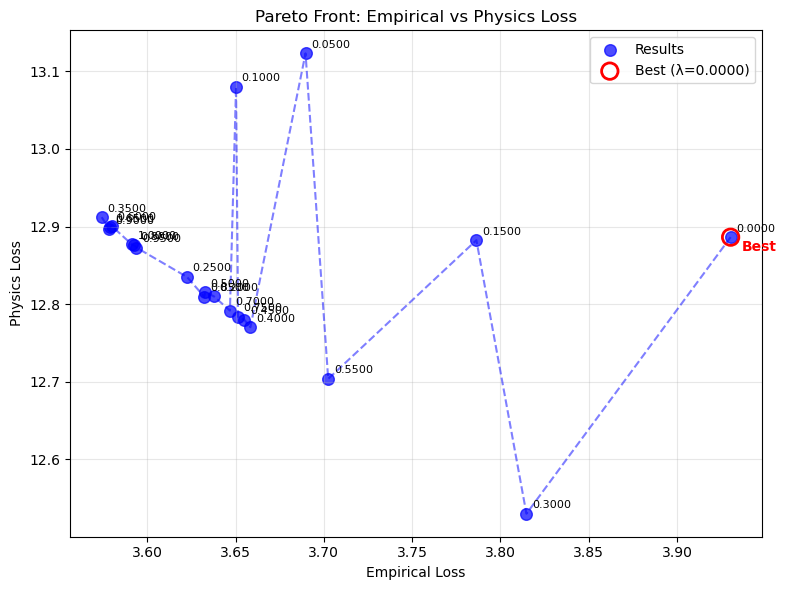

In [20]:
def create_pareto_plot(successful_results, best_result=None, save_path="pareto_front_01.png"):
    """
    Creates a Pareto front plot using empirical and physics loss from the successful runs.

    Parameters:
        successful_results (list): List of result dicts returned from run_search().
        best_result (dict): The best result to highlight (optional).
        save_path (str): Where to save the figure.
    """
    # Extract data
    emp_losses = np.array([r['test_emp_loss'] for r in successful_results])
    phy_losses = np.array([r['test_phy_loss'] for r in successful_results])
    weights = [r['hyperparameters']['physics_weight'] for r in successful_results]

    # Plot points
    plt.figure(figsize=(8, 6))
    plt.scatter(emp_losses, phy_losses, s=70, c='blue', alpha=0.7, label='Results')

    # Annotate weights
    for i, w in enumerate(weights):
        plt.annotate(f"{w:.4f}", (emp_losses[i], phy_losses[i]), fontsize=8, xytext=(4, 4), textcoords='offset points')

    # Draw connecting polyline (sorted by emp loss)
    sorted_idx = np.argsort(emp_losses)
    plt.plot(emp_losses[sorted_idx], phy_losses[sorted_idx], 'b--', lw=1.5, alpha=0.5)

    # Highlight best result
    if best_result:
        best_emp = best_result['test_emp_loss']
        best_phy = best_result['test_phy_loss']
        best_weight = best_result['hyperparameters']['physics_weight']
        plt.scatter(best_emp, best_phy, s=140, facecolors='none', edgecolors='red', linewidths=2,
                    label=f'Best (λ={best_weight:.4f})')
        plt.annotate("Best", (best_emp, best_phy), fontsize=10, fontweight='bold',
                     xytext=(8, -10), textcoords='offset points', color='red')

    # Formatting
    plt.xlabel("Empirical Loss")
    plt.ylabel("Physics Loss")
    plt.title("Pareto Front: Empirical vs Physics Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

    
create_pareto_plot(all_results, best_result)

<h3>BFE Loss Function without PCGrad</h3>

In [21]:
print(best_result['hyperparameters']['physics_weight'])

0.0


---------- Hyperparameter combinations ------------
Epoch : 250;  physics_weight: 0.0;
Epoch 1/250


Inside call


Inside call


1/1 [==============================] - ETA: 0s - loss: 8.9637

1/1 [==============================] - 41s 41s/step - loss: 8.9637


Epoch 2/250


1/1 [==============================] - ETA: 0s - loss: 5.8654

1/1 [==============================] - 1s 764ms/step - loss: 5.8654


Epoch 3/250


1/1 [==============================] - ETA: 0s - loss: 5.7728

1/1 [==============================] - 1s 965ms/step - loss: 5.7728


Epoch 4/250


1/1 [==============================] - ETA: 0s - loss: 5.7005

1/1 [==============================] - 1s 959ms/step - loss: 5.7005


Epoch 5/250


1/1 [==============================] - ETA: 0s - loss: 5.6349

1/1 [==============================] - 1s 940ms/step - loss: 5.6349


Epoch 6/250


1/1 [==============================] - ETA: 0s - loss: 5.5676

1/1 [==============================] - 1s 958ms/step - loss: 5.5676


Epoch 7/250


1/1 [==============================] - ETA: 0s - loss: 5.4980

1/1 [==============================] - 1s 904ms/step - loss: 5.4980


Epoch 8/250


1/1 [==============================] - ETA: 0s - loss: 5.4292

1/1 [==============================] - 1s 989ms/step - loss: 5.4292


Epoch 9/250


1/1 [==============================] - ETA: 0s - loss: 5.3647

1/1 [==============================] - 1s 919ms/step - loss: 5.3647


Epoch 10/250


1/1 [==============================] - ETA: 0s - loss: 5.3067

1/1 [==============================] - 1s 982ms/step - loss: 5.3067


Epoch 11/250


1/1 [==============================] - ETA: 0s - loss: 5.2559

1/1 [==============================] - 1s 841ms/step - loss: 5.2559


Epoch 12/250


1/1 [==============================] - ETA: 0s - loss: 5.2107

1/1 [==============================] - 1s 641ms/step - loss: 5.2107


Epoch 13/250


1/1 [==============================] - ETA: 0s - loss: 5.1688

1/1 [==============================] - 1s 856ms/step - loss: 5.1688


Epoch 14/250


1/1 [==============================] - ETA: 0s - loss: 5.1280

1/1 [==============================] - 1s 873ms/step - loss: 5.1280


Epoch 15/250


1/1 [==============================] - ETA: 0s - loss: 5.0873

1/1 [==============================] - 1s 855ms/step - loss: 5.0873


Epoch 16/250


1/1 [==============================] - ETA: 0s - loss: 5.0467

1/1 [==============================] - 1s 999ms/step - loss: 5.0467


Epoch 17/250


1/1 [==============================] - ETA: 0s - loss: 5.0065

1/1 [==============================] - 1s 946ms/step - loss: 5.0065


Epoch 18/250


1/1 [==============================] - ETA: 0s - loss: 4.9672

1/1 [==============================] - 1s 929ms/step - loss: 4.9672


Epoch 19/250


1/1 [==============================] - ETA: 0s - loss: 4.9289

1/1 [==============================] - 1s 946ms/step - loss: 4.9289


Epoch 20/250


1/1 [==============================] - ETA: 0s - loss: 4.8915

1/1 [==============================] - 1s 908ms/step - loss: 4.8915


Epoch 21/250


1/1 [==============================] - ETA: 0s - loss: 4.8548

1/1 [==============================] - 1s 1s/step - loss: 4.8548


Epoch 22/250


1/1 [==============================] - ETA: 0s - loss: 4.8184

1/1 [==============================] - 1s 957ms/step - loss: 4.8184


Epoch 23/250


1/1 [==============================] - ETA: 0s - loss: 4.7820

1/1 [==============================] - 1s 1s/step - loss: 4.7820


Epoch 24/250


1/1 [==============================] - ETA: 0s - loss: 4.7453

1/1 [==============================] - 1s 894ms/step - loss: 4.7453


Epoch 25/250


1/1 [==============================] - ETA: 0s - loss: 4.7082

1/1 [==============================] - 1s 911ms/step - loss: 4.7082


Epoch 26/250


1/1 [==============================] - ETA: 0s - loss: 4.6706

1/1 [==============================] - 1s 913ms/step - loss: 4.6706


Epoch 27/250


1/1 [==============================] - ETA: 0s - loss: 4.6327

1/1 [==============================] - 1s 921ms/step - loss: 4.6327


Epoch 28/250


1/1 [==============================] - ETA: 0s - loss: 4.5946

1/1 [==============================] - 1s 901ms/step - loss: 4.5946


Epoch 29/250


1/1 [==============================] - ETA: 0s - loss: 4.5566

1/1 [==============================] - 1s 816ms/step - loss: 4.5566


Epoch 30/250


1/1 [==============================] - ETA: 0s - loss: 4.5188

1/1 [==============================] - 1s 963ms/step - loss: 4.5188


Epoch 31/250


1/1 [==============================] - ETA: 0s - loss: 4.4812

1/1 [==============================] - 1s 1s/step - loss: 4.4812


Epoch 32/250


1/1 [==============================] - ETA: 0s - loss: 4.4441

1/1 [==============================] - 1s 1s/step - loss: 4.4441


Epoch 33/250


1/1 [==============================] - ETA: 0s - loss: 4.4073

1/1 [==============================] - 1s 954ms/step - loss: 4.4073


Epoch 34/250


1/1 [==============================] - ETA: 0s - loss: 4.3708

1/1 [==============================] - 1s 883ms/step - loss: 4.3708


Epoch 35/250


1/1 [==============================] - ETA: 0s - loss: 4.3347

1/1 [==============================] - 1s 937ms/step - loss: 4.3347


Epoch 36/250


1/1 [==============================] - ETA: 0s - loss: 4.2990

1/1 [==============================] - 1s 875ms/step - loss: 4.2990


Epoch 37/250


1/1 [==============================] - ETA: 0s - loss: 4.2638

1/1 [==============================] - 1s 932ms/step - loss: 4.2638


Epoch 38/250


1/1 [==============================] - ETA: 0s - loss: 4.2290

1/1 [==============================] - 1s 856ms/step - loss: 4.2290


Epoch 39/250


1/1 [==============================] - ETA: 0s - loss: 4.1949

1/1 [==============================] - 1s 879ms/step - loss: 4.1949


Epoch 40/250


1/1 [==============================] - ETA: 0s - loss: 4.1613

1/1 [==============================] - 1s 910ms/step - loss: 4.1613


Epoch 41/250


1/1 [==============================] - ETA: 0s - loss: 4.1283

1/1 [==============================] - 1s 924ms/step - loss: 4.1283


Epoch 42/250


1/1 [==============================] - ETA: 0s - loss: 4.0958

1/1 [==============================] - 1s 941ms/step - loss: 4.0958


Epoch 43/250


1/1 [==============================] - ETA: 0s - loss: 4.0638

1/1 [==============================] - 1s 910ms/step - loss: 4.0638


Epoch 44/250


1/1 [==============================] - ETA: 0s - loss: 4.0322

1/1 [==============================] - 1s 851ms/step - loss: 4.0322


Epoch 45/250


1/1 [==============================] - ETA: 0s - loss: 4.0009

1/1 [==============================] - 1s 840ms/step - loss: 4.0009


Epoch 46/250


1/1 [==============================] - ETA: 0s - loss: 3.9701

1/1 [==============================] - 1s 914ms/step - loss: 3.9701


Epoch 47/250


1/1 [==============================] - ETA: 0s - loss: 3.9396

1/1 [==============================] - 1s 934ms/step - loss: 3.9396


Epoch 48/250


1/1 [==============================] - ETA: 0s - loss: 3.9094

1/1 [==============================] - 1s 839ms/step - loss: 3.9094


Epoch 49/250


1/1 [==============================] - ETA: 0s - loss: 3.8797

1/1 [==============================] - 1s 953ms/step - loss: 3.8797


Epoch 50/250


1/1 [==============================] - ETA: 0s - loss: 3.8505

1/1 [==============================] - 1s 946ms/step - loss: 3.8505


Epoch 51/250


1/1 [==============================] - ETA: 0s - loss: 3.8217

1/1 [==============================] - 1s 960ms/step - loss: 3.8217


Epoch 52/250


1/1 [==============================] - ETA: 0s - loss: 3.7933

1/1 [==============================] - 1s 897ms/step - loss: 3.7933


Epoch 53/250


1/1 [==============================] - ETA: 0s - loss: 3.7655

1/1 [==============================] - 1s 952ms/step - loss: 3.7655


Epoch 54/250


1/1 [==============================] - ETA: 0s - loss: 3.7380

1/1 [==============================] - 1s 933ms/step - loss: 3.7380


Epoch 55/250


1/1 [==============================] - ETA: 0s - loss: 3.7112

1/1 [==============================] - 1s 902ms/step - loss: 3.7112


Epoch 56/250


1/1 [==============================] - ETA: 0s - loss: 3.6848

1/1 [==============================] - 1s 888ms/step - loss: 3.6848


Epoch 57/250


1/1 [==============================] - ETA: 0s - loss: 3.6591

1/1 [==============================] - 1s 837ms/step - loss: 3.6591


Epoch 58/250


1/1 [==============================] - ETA: 0s - loss: 3.6340

1/1 [==============================] - 1s 954ms/step - loss: 3.6340


Epoch 59/250


1/1 [==============================] - ETA: 0s - loss: 3.6094

1/1 [==============================] - 1s 922ms/step - loss: 3.6094


Epoch 60/250


1/1 [==============================] - ETA: 0s - loss: 3.5854

1/1 [==============================] - 1s 850ms/step - loss: 3.5854


Epoch 61/250


1/1 [==============================] - ETA: 0s - loss: 3.5620

1/1 [==============================] - 1s 858ms/step - loss: 3.5620


Epoch 62/250


1/1 [==============================] - ETA: 0s - loss: 3.5391

1/1 [==============================] - 1s 944ms/step - loss: 3.5391


Epoch 63/250


1/1 [==============================] - ETA: 0s - loss: 3.5168

1/1 [==============================] - 1s 901ms/step - loss: 3.5168


Epoch 64/250


1/1 [==============================] - ETA: 0s - loss: 3.4951

1/1 [==============================] - 1s 976ms/step - loss: 3.4951


Epoch 65/250


1/1 [==============================] - ETA: 0s - loss: 3.4739

1/1 [==============================] - 1s 923ms/step - loss: 3.4739


Epoch 66/250


1/1 [==============================] - ETA: 0s - loss: 3.4533

1/1 [==============================] - 1s 953ms/step - loss: 3.4533


Epoch 67/250


1/1 [==============================] - ETA: 0s - loss: 3.4332

1/1 [==============================] - 1s 972ms/step - loss: 3.4332


Epoch 68/250


1/1 [==============================] - ETA: 0s - loss: 3.4137

1/1 [==============================] - 1s 1s/step - loss: 3.4137


Epoch 69/250


1/1 [==============================] - ETA: 0s - loss: 3.3947

1/1 [==============================] - 1s 909ms/step - loss: 3.3947


Epoch 70/250


1/1 [==============================] - ETA: 0s - loss: 3.3763

1/1 [==============================] - 1s 927ms/step - loss: 3.3763


Epoch 71/250


1/1 [==============================] - ETA: 0s - loss: 3.3585

1/1 [==============================] - 1s 916ms/step - loss: 3.3585


Epoch 72/250


1/1 [==============================] - ETA: 0s - loss: 3.3412

1/1 [==============================] - 1s 881ms/step - loss: 3.3412


Epoch 73/250


1/1 [==============================] - ETA: 0s - loss: 3.3244

1/1 [==============================] - 1s 999ms/step - loss: 3.3244


Epoch 74/250


1/1 [==============================] - ETA: 0s - loss: 3.3082

1/1 [==============================] - 1s 857ms/step - loss: 3.3082


Epoch 75/250


1/1 [==============================] - ETA: 0s - loss: 3.2925

1/1 [==============================] - 1s 1s/step - loss: 3.2925


Epoch 76/250


1/1 [==============================] - ETA: 0s - loss: 3.2774

1/1 [==============================] - 1s 822ms/step - loss: 3.2774


Epoch 77/250


1/1 [==============================] - ETA: 0s - loss: 3.2627

1/1 [==============================] - 1s 852ms/step - loss: 3.2627


Epoch 78/250


1/1 [==============================] - ETA: 0s - loss: 3.2486

1/1 [==============================] - 1s 896ms/step - loss: 3.2486


Epoch 79/250


1/1 [==============================] - ETA: 0s - loss: 3.2350

1/1 [==============================] - 1s 898ms/step - loss: 3.2350


Epoch 80/250


1/1 [==============================] - ETA: 0s - loss: 3.2219

1/1 [==============================] - 1s 866ms/step - loss: 3.2219


Epoch 81/250


1/1 [==============================] - ETA: 0s - loss: 3.2093

1/1 [==============================] - 1s 887ms/step - loss: 3.2093


Epoch 82/250


1/1 [==============================] - ETA: 0s - loss: 3.1972

1/1 [==============================] - 1s 895ms/step - loss: 3.1972


Epoch 83/250


1/1 [==============================] - ETA: 0s - loss: 3.1854

1/1 [==============================] - 1s 881ms/step - loss: 3.1854


Epoch 84/250


1/1 [==============================] - ETA: 0s - loss: 3.1742

1/1 [==============================] - 1s 965ms/step - loss: 3.1742


Epoch 85/250


1/1 [==============================] - ETA: 0s - loss: 3.1634

1/1 [==============================] - 1s 1s/step - loss: 3.1634


Epoch 86/250


1/1 [==============================] - ETA: 0s - loss: 3.1529

1/1 [==============================] - 1s 1s/step - loss: 3.1529


Epoch 87/250


1/1 [==============================] - ETA: 0s - loss: 3.1429

1/1 [==============================] - 1s 1s/step - loss: 3.1429


Epoch 88/250


1/1 [==============================] - ETA: 0s - loss: 3.1333

1/1 [==============================] - 1s 976ms/step - loss: 3.1333


Epoch 89/250


1/1 [==============================] - ETA: 0s - loss: 3.1241

1/1 [==============================] - 1s 1s/step - loss: 3.1241


Epoch 90/250


1/1 [==============================] - ETA: 0s - loss: 3.1153

1/1 [==============================] - 1s 1s/step - loss: 3.1153


Epoch 91/250


1/1 [==============================] - ETA: 0s - loss: 3.1068

1/1 [==============================] - 1s 1s/step - loss: 3.1068


Epoch 92/250


1/1 [==============================] - ETA: 0s - loss: 3.0987

1/1 [==============================] - 1s 886ms/step - loss: 3.0987


Epoch 93/250


1/1 [==============================] - ETA: 0s - loss: 3.0909

1/1 [==============================] - 1s 987ms/step - loss: 3.0909


Epoch 94/250


1/1 [==============================] - ETA: 0s - loss: 3.0834

1/1 [==============================] - 1s 1000ms/step - loss: 3.0834


Epoch 95/250


1/1 [==============================] - ETA: 0s - loss: 3.0762

1/1 [==============================] - 1s 909ms/step - loss: 3.0762


Epoch 96/250


1/1 [==============================] - ETA: 0s - loss: 3.0694

1/1 [==============================] - 1s 894ms/step - loss: 3.0694


Epoch 97/250


1/1 [==============================] - ETA: 0s - loss: 3.0628

1/1 [==============================] - 1s 947ms/step - loss: 3.0628


Epoch 98/250


1/1 [==============================] - ETA: 0s - loss: 3.0564

1/1 [==============================] - 1s 939ms/step - loss: 3.0564


Epoch 99/250


1/1 [==============================] - ETA: 0s - loss: 3.0504

1/1 [==============================] - 1s 979ms/step - loss: 3.0504


Epoch 100/250


1/1 [==============================] - ETA: 0s - loss: 3.0445

1/1 [==============================] - 1s 878ms/step - loss: 3.0445


Epoch 101/250


1/1 [==============================] - ETA: 0s - loss: 3.0389

1/1 [==============================] - 1s 901ms/step - loss: 3.0389


Epoch 102/250


1/1 [==============================] - ETA: 0s - loss: 3.0336

1/1 [==============================] - 1s 927ms/step - loss: 3.0336


Epoch 103/250


1/1 [==============================] - ETA: 0s - loss: 3.0284

1/1 [==============================] - 1s 923ms/step - loss: 3.0284


Epoch 104/250


1/1 [==============================] - ETA: 0s - loss: 3.0234

1/1 [==============================] - 1s 903ms/step - loss: 3.0234


Epoch 105/250


1/1 [==============================] - ETA: 0s - loss: 3.0186

1/1 [==============================] - 1s 977ms/step - loss: 3.0186


Epoch 106/250


1/1 [==============================] - ETA: 0s - loss: 3.0140

1/1 [==============================] - 1s 898ms/step - loss: 3.0140


Epoch 107/250


1/1 [==============================] - ETA: 0s - loss: 3.0096

1/1 [==============================] - 1s 926ms/step - loss: 3.0096


Epoch 108/250


1/1 [==============================] - ETA: 0s - loss: 3.0053

1/1 [==============================] - 1s 870ms/step - loss: 3.0053


Epoch 109/250


1/1 [==============================] - ETA: 0s - loss: 3.0012

1/1 [==============================] - 1s 780ms/step - loss: 3.0012


Epoch 110/250


1/1 [==============================] - ETA: 0s - loss: 2.9971

1/1 [==============================] - 1s 963ms/step - loss: 2.9971


Epoch 111/250


1/1 [==============================] - ETA: 0s - loss: 2.9933

1/1 [==============================] - 1s 826ms/step - loss: 2.9933


Epoch 112/250


1/1 [==============================] - ETA: 0s - loss: 2.9895

1/1 [==============================] - 1s 831ms/step - loss: 2.9895


Epoch 113/250


1/1 [==============================] - ETA: 0s - loss: 2.9859

1/1 [==============================] - 1s 772ms/step - loss: 2.9859


Epoch 114/250


1/1 [==============================] - ETA: 0s - loss: 2.9824

1/1 [==============================] - 1s 920ms/step - loss: 2.9824


Epoch 115/250


1/1 [==============================] - ETA: 0s - loss: 2.9790

1/1 [==============================] - 1s 871ms/step - loss: 2.9790


Epoch 116/250


1/1 [==============================] - ETA: 0s - loss: 2.9756

1/1 [==============================] - 1s 914ms/step - loss: 2.9756


Epoch 117/250


1/1 [==============================] - ETA: 0s - loss: 2.9725

1/1 [==============================] - 1s 888ms/step - loss: 2.9725


Epoch 118/250


1/1 [==============================] - ETA: 0s - loss: 2.9693

1/1 [==============================] - 1s 887ms/step - loss: 2.9693


Epoch 119/250


1/1 [==============================] - ETA: 0s - loss: 2.9662

1/1 [==============================] - 1s 898ms/step - loss: 2.9662


Epoch 120/250


1/1 [==============================] - ETA: 0s - loss: 2.9632

1/1 [==============================] - 1s 1s/step - loss: 2.9632


Epoch 121/250


1/1 [==============================] - ETA: 0s - loss: 2.9603

1/1 [==============================] - 1s 881ms/step - loss: 2.9603


Epoch 122/250


1/1 [==============================] - ETA: 0s - loss: 2.9575

1/1 [==============================] - 1s 929ms/step - loss: 2.9575


Epoch 123/250


1/1 [==============================] - ETA: 0s - loss: 2.9547

1/1 [==============================] - 1s 939ms/step - loss: 2.9547


Epoch 124/250


1/1 [==============================] - ETA: 0s - loss: 2.9519

1/1 [==============================] - 1s 928ms/step - loss: 2.9519


Epoch 125/250


1/1 [==============================] - ETA: 0s - loss: 2.9492

1/1 [==============================] - 1s 863ms/step - loss: 2.9492


Epoch 126/250


1/1 [==============================] - ETA: 0s - loss: 2.9466

1/1 [==============================] - 1s 880ms/step - loss: 2.9466


Epoch 127/250


1/1 [==============================] - ETA: 0s - loss: 2.9440

1/1 [==============================] - 1s 899ms/step - loss: 2.9440


Epoch 128/250


1/1 [==============================] - ETA: 0s - loss: 2.9414

1/1 [==============================] - 1s 878ms/step - loss: 2.9414


Epoch 129/250


1/1 [==============================] - ETA: 0s - loss: 2.9389

1/1 [==============================] - 1s 946ms/step - loss: 2.9389


Epoch 130/250


1/1 [==============================] - ETA: 0s - loss: 2.9364

1/1 [==============================] - 1s 957ms/step - loss: 2.9364


Epoch 131/250


1/1 [==============================] - ETA: 0s - loss: 2.9340

1/1 [==============================] - 1s 917ms/step - loss: 2.9340


Epoch 132/250


1/1 [==============================] - ETA: 0s - loss: 2.9316

1/1 [==============================] - 1s 903ms/step - loss: 2.9316


Epoch 133/250


1/1 [==============================] - ETA: 0s - loss: 2.9292

1/1 [==============================] - 1s 926ms/step - loss: 2.9292


Epoch 134/250


1/1 [==============================] - ETA: 0s - loss: 2.9269

1/1 [==============================] - 1s 941ms/step - loss: 2.9269


Epoch 135/250


1/1 [==============================] - ETA: 0s - loss: 2.9246

1/1 [==============================] - 1s 939ms/step - loss: 2.9246


Epoch 136/250


1/1 [==============================] - ETA: 0s - loss: 2.9223

1/1 [==============================] - 1s 898ms/step - loss: 2.9223


Epoch 137/250


1/1 [==============================] - ETA: 0s - loss: 2.9200

1/1 [==============================] - 1s 892ms/step - loss: 2.9200


Epoch 138/250


1/1 [==============================] - ETA: 0s - loss: 2.9178

1/1 [==============================] - 1s 934ms/step - loss: 2.9178


Epoch 139/250


1/1 [==============================] - ETA: 0s - loss: 2.9156

1/1 [==============================] - 1s 923ms/step - loss: 2.9156


Epoch 140/250


1/1 [==============================] - ETA: 0s - loss: 2.9134

1/1 [==============================] - 1s 900ms/step - loss: 2.9134


Epoch 141/250


1/1 [==============================] - ETA: 0s - loss: 2.9113

1/1 [==============================] - 1s 899ms/step - loss: 2.9113


Epoch 142/250


1/1 [==============================] - ETA: 0s - loss: 2.9091

1/1 [==============================] - 1s 1s/step - loss: 2.9091


Epoch 143/250


1/1 [==============================] - ETA: 0s - loss: 2.9070

1/1 [==============================] - 1s 1s/step - loss: 2.9070


Epoch 144/250


1/1 [==============================] - ETA: 0s - loss: 2.9049

1/1 [==============================] - 1s 854ms/step - loss: 2.9049


Epoch 145/250


1/1 [==============================] - ETA: 0s - loss: 2.9029

1/1 [==============================] - 1s 906ms/step - loss: 2.9029


Epoch 146/250


1/1 [==============================] - ETA: 0s - loss: 2.9008

1/1 [==============================] - 1s 785ms/step - loss: 2.9008


Epoch 147/250


1/1 [==============================] - ETA: 0s - loss: 2.8988

1/1 [==============================] - 1s 884ms/step - loss: 2.8988


Epoch 148/250


1/1 [==============================] - ETA: 0s - loss: 2.8968

1/1 [==============================] - 1s 912ms/step - loss: 2.8968


Epoch 149/250


1/1 [==============================] - ETA: 0s - loss: 2.8948

1/1 [==============================] - 1s 933ms/step - loss: 2.8948


Epoch 150/250


1/1 [==============================] - ETA: 0s - loss: 2.8928

1/1 [==============================] - 1s 915ms/step - loss: 2.8928


Epoch 151/250


1/1 [==============================] - ETA: 0s - loss: 2.8909

1/1 [==============================] - 1s 909ms/step - loss: 2.8909


Epoch 152/250


1/1 [==============================] - ETA: 0s - loss: 2.8889

1/1 [==============================] - 1s 940ms/step - loss: 2.8889


Epoch 153/250


1/1 [==============================] - ETA: 0s - loss: 2.8870

1/1 [==============================] - 1s 891ms/step - loss: 2.8870


Epoch 154/250


1/1 [==============================] - ETA: 0s - loss: 2.8851

1/1 [==============================] - 1s 912ms/step - loss: 2.8851


Epoch 155/250


1/1 [==============================] - ETA: 0s - loss: 2.8833

1/1 [==============================] - 1s 932ms/step - loss: 2.8833


Epoch 156/250


1/1 [==============================] - ETA: 0s - loss: 2.8814

1/1 [==============================] - 1s 932ms/step - loss: 2.8814


Epoch 157/250


1/1 [==============================] - ETA: 0s - loss: 2.8795

1/1 [==============================] - 1s 941ms/step - loss: 2.8795


Epoch 158/250


1/1 [==============================] - ETA: 0s - loss: 2.8777

1/1 [==============================] - 1s 852ms/step - loss: 2.8777


Epoch 159/250


1/1 [==============================] - ETA: 0s - loss: 2.8759

1/1 [==============================] - 1s 800ms/step - loss: 2.8759


Epoch 160/250


1/1 [==============================] - ETA: 0s - loss: 2.8741

1/1 [==============================] - 1s 872ms/step - loss: 2.8741


Epoch 161/250


1/1 [==============================] - ETA: 0s - loss: 2.8723

1/1 [==============================] - 1s 907ms/step - loss: 2.8723


Epoch 162/250


1/1 [==============================] - ETA: 0s - loss: 2.8705

1/1 [==============================] - 1s 903ms/step - loss: 2.8705


Epoch 163/250


1/1 [==============================] - ETA: 0s - loss: 2.8688

1/1 [==============================] - 1s 883ms/step - loss: 2.8688


Epoch 164/250


1/1 [==============================] - ETA: 0s - loss: 2.8671

1/1 [==============================] - 1s 929ms/step - loss: 2.8671


Epoch 165/250


1/1 [==============================] - ETA: 0s - loss: 2.8653

1/1 [==============================] - 1s 940ms/step - loss: 2.8653


Epoch 166/250


1/1 [==============================] - ETA: 0s - loss: 2.8637

1/1 [==============================] - 1s 936ms/step - loss: 2.8637


Epoch 167/250


1/1 [==============================] - ETA: 0s - loss: 2.8620

1/1 [==============================] - 1s 969ms/step - loss: 2.8620


Epoch 168/250


1/1 [==============================] - ETA: 0s - loss: 2.8604

1/1 [==============================] - 1s 987ms/step - loss: 2.8604


Epoch 169/250


1/1 [==============================] - ETA: 0s - loss: 2.8587

1/1 [==============================] - 1s 949ms/step - loss: 2.8587


Epoch 170/250


1/1 [==============================] - ETA: 0s - loss: 2.8570

1/1 [==============================] - 1s 986ms/step - loss: 2.8570


Epoch 171/250


1/1 [==============================] - ETA: 0s - loss: 2.8555

1/1 [==============================] - 1s 931ms/step - loss: 2.8555


Epoch 172/250


1/1 [==============================] - ETA: 0s - loss: 2.8538

1/1 [==============================] - 1s 1s/step - loss: 2.8538


Epoch 173/250


1/1 [==============================] - ETA: 0s - loss: 2.8523

1/1 [==============================] - 1s 980ms/step - loss: 2.8523


Epoch 174/250


1/1 [==============================] - ETA: 0s - loss: 2.8507

1/1 [==============================] - 1s 839ms/step - loss: 2.8507


Epoch 175/250


1/1 [==============================] - ETA: 0s - loss: 2.8492

1/1 [==============================] - 1s 850ms/step - loss: 2.8492


Epoch 176/250


1/1 [==============================] - ETA: 0s - loss: 2.8476

1/1 [==============================] - 1s 932ms/step - loss: 2.8476


Epoch 177/250


1/1 [==============================] - ETA: 0s - loss: 2.8461

1/1 [==============================] - 1s 888ms/step - loss: 2.8461


Epoch 178/250


1/1 [==============================] - ETA: 0s - loss: 2.8446

1/1 [==============================] - 1s 863ms/step - loss: 2.8446


Epoch 179/250


1/1 [==============================] - ETA: 0s - loss: 2.8431

1/1 [==============================] - 1s 896ms/step - loss: 2.8431


Epoch 180/250


1/1 [==============================] - ETA: 0s - loss: 2.8416

1/1 [==============================] - 1s 945ms/step - loss: 2.8416


Epoch 181/250


1/1 [==============================] - ETA: 0s - loss: 2.8402

1/1 [==============================] - 1s 969ms/step - loss: 2.8402


Epoch 182/250


1/1 [==============================] - ETA: 0s - loss: 2.8387

1/1 [==============================] - 1s 878ms/step - loss: 2.8387


Epoch 183/250


1/1 [==============================] - ETA: 0s - loss: 2.8373

1/1 [==============================] - 1s 933ms/step - loss: 2.8373


Epoch 184/250


1/1 [==============================] - ETA: 0s - loss: 2.8359

1/1 [==============================] - 1s 935ms/step - loss: 2.8359


Epoch 185/250


1/1 [==============================] - ETA: 0s - loss: 2.8345

1/1 [==============================] - 1s 923ms/step - loss: 2.8345


Epoch 186/250


1/1 [==============================] - ETA: 0s - loss: 2.8331

1/1 [==============================] - 1s 883ms/step - loss: 2.8331


Epoch 187/250


1/1 [==============================] - ETA: 0s - loss: 2.8317

1/1 [==============================] - 1s 910ms/step - loss: 2.8317


Epoch 188/250


1/1 [==============================] - ETA: 0s - loss: 2.8303

1/1 [==============================] - 1s 939ms/step - loss: 2.8303


Epoch 189/250


1/1 [==============================] - ETA: 0s - loss: 2.8290

1/1 [==============================] - 1s 932ms/step - loss: 2.8290


Epoch 190/250


1/1 [==============================] - ETA: 0s - loss: 2.8277

1/1 [==============================] - 1s 867ms/step - loss: 2.8277


Epoch 191/250


1/1 [==============================] - ETA: 0s - loss: 2.8264

1/1 [==============================] - 1s 872ms/step - loss: 2.8264


Epoch 192/250


1/1 [==============================] - ETA: 0s - loss: 2.8251

1/1 [==============================] - 1s 837ms/step - loss: 2.8251


Epoch 193/250


1/1 [==============================] - ETA: 0s - loss: 2.8238

1/1 [==============================] - 1s 907ms/step - loss: 2.8238


Epoch 194/250


1/1 [==============================] - ETA: 0s - loss: 2.8225

1/1 [==============================] - 1s 932ms/step - loss: 2.8225


Epoch 195/250


1/1 [==============================] - ETA: 0s - loss: 2.8212

1/1 [==============================] - 1s 960ms/step - loss: 2.8212


Epoch 196/250


1/1 [==============================] - ETA: 0s - loss: 2.8200

1/1 [==============================] - 1s 929ms/step - loss: 2.8200


Epoch 197/250


1/1 [==============================] - ETA: 0s - loss: 2.8187

1/1 [==============================] - 1s 922ms/step - loss: 2.8187


Epoch 198/250


1/1 [==============================] - ETA: 0s - loss: 2.8175

1/1 [==============================] - 1s 978ms/step - loss: 2.8175


Epoch 199/250


1/1 [==============================] - ETA: 0s - loss: 2.8163

1/1 [==============================] - 1s 942ms/step - loss: 2.8163


Epoch 200/250


1/1 [==============================] - ETA: 0s - loss: 2.8151

1/1 [==============================] - 1s 931ms/step - loss: 2.8151


Epoch 201/250


1/1 [==============================] - ETA: 0s - loss: 2.8138

1/1 [==============================] - 1s 967ms/step - loss: 2.8138


Epoch 202/250


1/1 [==============================] - ETA: 0s - loss: 2.8127

1/1 [==============================] - 1s 1s/step - loss: 2.8127


Epoch 203/250


1/1 [==============================] - ETA: 0s - loss: 2.8115

1/1 [==============================] - 1s 1s/step - loss: 2.8115


Epoch 204/250


1/1 [==============================] - ETA: 0s - loss: 2.8104

1/1 [==============================] - 1s 1s/step - loss: 2.8104


Epoch 205/250


1/1 [==============================] - ETA: 0s - loss: 2.8092

1/1 [==============================] - 1s 1s/step - loss: 2.8092


Epoch 206/250


1/1 [==============================] - ETA: 0s - loss: 2.8081

1/1 [==============================] - 1s 916ms/step - loss: 2.8081


Epoch 207/250


1/1 [==============================] - ETA: 0s - loss: 2.8070

1/1 [==============================] - 1s 959ms/step - loss: 2.8070


Epoch 208/250


1/1 [==============================] - ETA: 0s - loss: 2.8059

1/1 [==============================] - 1s 943ms/step - loss: 2.8059


Epoch 209/250


1/1 [==============================] - ETA: 0s - loss: 2.8048

1/1 [==============================] - 1s 1s/step - loss: 2.8048


Epoch 210/250


1/1 [==============================] - ETA: 0s - loss: 2.8037

1/1 [==============================] - 1s 894ms/step - loss: 2.8037


Epoch 211/250


1/1 [==============================] - ETA: 0s - loss: 2.8026

1/1 [==============================] - 1s 919ms/step - loss: 2.8026


Epoch 212/250


1/1 [==============================] - ETA: 0s - loss: 2.8016

1/1 [==============================] - 1s 913ms/step - loss: 2.8016


Epoch 213/250


1/1 [==============================] - ETA: 0s - loss: 2.8005

1/1 [==============================] - 1s 954ms/step - loss: 2.8005


Epoch 214/250


1/1 [==============================] - ETA: 0s - loss: 2.7995

1/1 [==============================] - 1s 887ms/step - loss: 2.7995


Epoch 215/250


1/1 [==============================] - ETA: 0s - loss: 2.7985

1/1 [==============================] - 1s 922ms/step - loss: 2.7985


Epoch 216/250


1/1 [==============================] - ETA: 0s - loss: 2.7974

1/1 [==============================] - 1s 913ms/step - loss: 2.7974


Epoch 217/250


1/1 [==============================] - ETA: 0s - loss: 2.7964

1/1 [==============================] - 1s 932ms/step - loss: 2.7964


Epoch 218/250


1/1 [==============================] - ETA: 0s - loss: 2.7954

1/1 [==============================] - 1s 853ms/step - loss: 2.7954


Epoch 219/250


1/1 [==============================] - ETA: 0s - loss: 2.7944

1/1 [==============================] - 1s 890ms/step - loss: 2.7944


Epoch 220/250


1/1 [==============================] - ETA: 0s - loss: 2.7934

1/1 [==============================] - 1s 949ms/step - loss: 2.7934


Epoch 221/250


1/1 [==============================] - ETA: 0s - loss: 2.7924

1/1 [==============================] - 1s 987ms/step - loss: 2.7924


Epoch 222/250


1/1 [==============================] - ETA: 0s - loss: 2.7915

1/1 [==============================] - 1s 870ms/step - loss: 2.7915


Epoch 223/250


1/1 [==============================] - ETA: 0s - loss: 2.7905

1/1 [==============================] - 1s 866ms/step - loss: 2.7905


Epoch 224/250


1/1 [==============================] - ETA: 0s - loss: 2.7896

1/1 [==============================] - 1s 961ms/step - loss: 2.7896


Epoch 225/250


1/1 [==============================] - ETA: 0s - loss: 2.7887

1/1 [==============================] - 1s 979ms/step - loss: 2.7887


Epoch 226/250


1/1 [==============================] - ETA: 0s - loss: 2.7877

1/1 [==============================] - 1s 933ms/step - loss: 2.7877


Epoch 227/250


1/1 [==============================] - ETA: 0s - loss: 2.7868

1/1 [==============================] - 1s 855ms/step - loss: 2.7868


Epoch 228/250


1/1 [==============================] - ETA: 0s - loss: 2.7859

1/1 [==============================] - 1s 969ms/step - loss: 2.7859


Epoch 229/250


1/1 [==============================] - ETA: 0s - loss: 2.7850

1/1 [==============================] - 1s 937ms/step - loss: 2.7850


Epoch 230/250


1/1 [==============================] - ETA: 0s - loss: 2.7841

1/1 [==============================] - 1s 917ms/step - loss: 2.7841


Epoch 231/250


1/1 [==============================] - ETA: 0s - loss: 2.7832

1/1 [==============================] - 1s 904ms/step - loss: 2.7832


Epoch 232/250


1/1 [==============================] - ETA: 0s - loss: 2.7824

1/1 [==============================] - 1s 920ms/step - loss: 2.7824


Epoch 233/250


1/1 [==============================] - ETA: 0s - loss: 2.7815

1/1 [==============================] - 1s 909ms/step - loss: 2.7815


Epoch 234/250


1/1 [==============================] - ETA: 0s - loss: 2.7806

1/1 [==============================] - 1s 1s/step - loss: 2.7806


Epoch 235/250


1/1 [==============================] - ETA: 0s - loss: 2.7798

1/1 [==============================] - 1s 897ms/step - loss: 2.7798


Epoch 236/250


1/1 [==============================] - ETA: 0s - loss: 2.7790

1/1 [==============================] - 1s 896ms/step - loss: 2.7790


Epoch 237/250


1/1 [==============================] - ETA: 0s - loss: 2.7781

1/1 [==============================] - 1s 933ms/step - loss: 2.7781


Epoch 238/250


1/1 [==============================] - ETA: 0s - loss: 2.7773

1/1 [==============================] - 1s 803ms/step - loss: 2.7773


Epoch 239/250


1/1 [==============================] - ETA: 0s - loss: 2.7765

1/1 [==============================] - 1s 813ms/step - loss: 2.7765


Epoch 240/250


1/1 [==============================] - ETA: 0s - loss: 2.7757

1/1 [==============================] - 1s 898ms/step - loss: 2.7757


Epoch 241/250


1/1 [==============================] - ETA: 0s - loss: 2.7748

1/1 [==============================] - 1s 888ms/step - loss: 2.7748


Epoch 242/250


1/1 [==============================] - ETA: 0s - loss: 2.7740

1/1 [==============================] - 1s 872ms/step - loss: 2.7740


Epoch 243/250


1/1 [==============================] - ETA: 0s - loss: 2.7732

1/1 [==============================] - 1s 853ms/step - loss: 2.7732


Epoch 244/250


1/1 [==============================] - ETA: 0s - loss: 2.7725

1/1 [==============================] - 1s 923ms/step - loss: 2.7725


Epoch 245/250


1/1 [==============================] - ETA: 0s - loss: 2.7717

1/1 [==============================] - 1s 898ms/step - loss: 2.7717


Epoch 246/250


1/1 [==============================] - ETA: 0s - loss: 2.7709

1/1 [==============================] - 1s 895ms/step - loss: 2.7709


Epoch 247/250


1/1 [==============================] - ETA: 0s - loss: 2.7702

1/1 [==============================] - 1s 972ms/step - loss: 2.7702


Epoch 248/250


1/1 [==============================] - ETA: 0s - loss: 2.7694

1/1 [==============================] - 1s 894ms/step - loss: 2.7694


Epoch 249/250


1/1 [==============================] - ETA: 0s - loss: 2.7687

1/1 [==============================] - 1s 918ms/step - loss: 2.7687


Epoch 250/250


1/1 [==============================] - ETA: 0s - loss: 2.7679

1/1 [==============================] - 1s 930ms/step - loss: 2.7679


Inside call


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


Inside call


1/1 [==============================] - ETA: 0s - loss: 3.1552

1/1 [==============================] - 3s 3s/step - loss: 3.1552


The mean absolute difference between y_tru & y_pred is : 2.4786274983088177


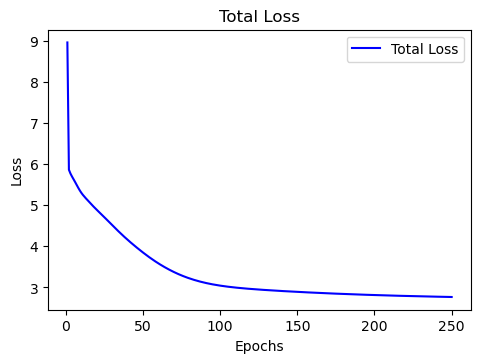

In [22]:
import csv

physics_hyperparam = [best_result['hyperparameters']['physics_weight']]
epochs = [250]
lr_schedule = 1e-4
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
        for physics_weight in physics_hyperparam:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCN_Hybrid()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 53])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback_Hybrid(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=10,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[loss_tracker,early_stopping])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 53])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(y_test - y_pred_test))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
            result_temp = {
                'name':'ΔΔG with Multi-Loss',
                'y_test': y_test,
                'test_loss': eval,
                'y_pred_test': y_pred_test,
                'MAD': y_difference,
                'all_losses': loss_tracker.total_losses,
                'empirical_losses': loss_tracker.empirical_losses if hasattr(loss_tracker, 'empirical_losses') else None,
                'physical_losses': loss_tracker.physical_losses if hasattr(loss_tracker, 'physical_losses') else None,
                'hyperparameters': {
                                    'physics_weight': physics_weight,
                                    'epochs': epoch,
                                    'initial_learning_rate': 0.005,
                                    'decay_steps': 10000,
                                    'decay_rate': 0.9
                }
            }

            
            # Also append to the all_results list for combined saving later
            results["multi_loss_run"] = result_temp
            all_results.append(result_temp)
        

        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        with open(outdir/'grid_search_results_no_pcgrad_05.pkl', 'wb') as f:
            pickle.dump({
                'best_result': best_result,
                'all_results': all_results,
                'results': results
            }, f)
        

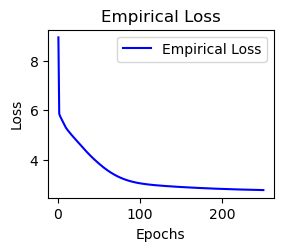

In [23]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [24]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

In [25]:
print(hybrid_y_true)
print(hybrid_y_pred)

[3.597 4.97  2.13  2.022 3.394 4.52  1.506 1.458 2.51  5.04  3.72  1.554
 1.575 4.73  3.344]
[ 7.4689426 -1.3287257  3.13447    1.5332738  3.3023167 10.084421
 -0.641775   2.3788548  6.427744   4.5434055  6.565531  -1.886587
 -2.6577053  4.8799534  1.6363012]


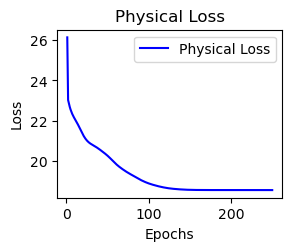

In [26]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

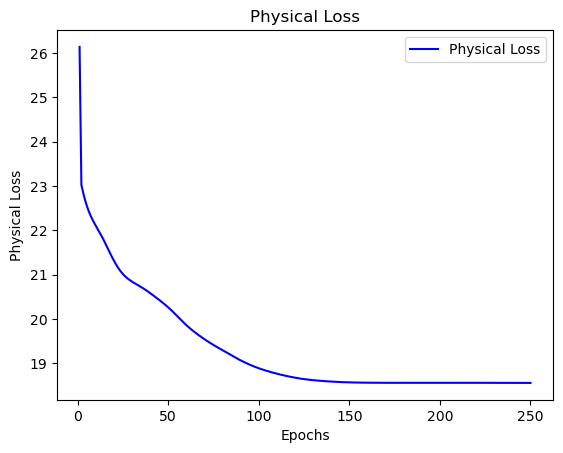

In [27]:
# hist is the History object returned by .fit()
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')

plt.xlabel('Epochs')
plt.ylabel('Physical Loss')
plt.legend()
plt.show()

In [28]:
print(len(loss_tracker.empirical_losses))
print(len(loss_tracker.physical_losses))

250
250


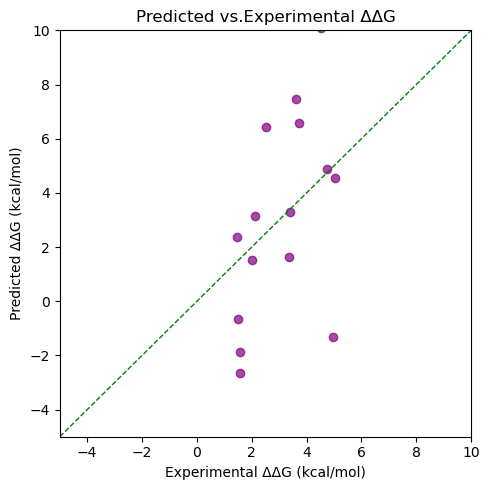

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Predicted vs.Experimental ΔΔG")
plt.scatter(y_test, y_pred_test, alpha=0.7, color="purple")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Predicted_vs_Experimental_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

In [30]:
# Comparison Graph Between BFE Loss Function with PCGrad and BFE Loss Function without PCGrad. We are comparing the physical and empirical losses
# and we want to create a table which has empirical loss, physical loss, and MAD comparison

# Extract metrics from PCGrad run
pcgrad_emp = best_result['test_emp_loss']
pcgrad_phy = best_result['test_phy_loss']
pcgrad_mad = best_result['MAD']

# Extract metrics from non-PCGrad run (take last recorded loss values)
no_pcgrad_res = results["multi_loss_run"]
no_pcgrad_emp = no_pcgrad_res['empirical_losses'][-1] if no_pcgrad_res['empirical_losses'] else None
no_pcgrad_phy = no_pcgrad_res['physical_losses'][-1] if no_pcgrad_res['physical_losses'] else None
no_pcgrad_mad = no_pcgrad_res['MAD']

# Build comparison table
comparison_df = pd.DataFrame({
    "Method": ["With PCGrad", "Without PCGrad"],
    "Empirical Loss": [pcgrad_emp, no_pcgrad_emp],
    "Physics Loss": [pcgrad_phy, no_pcgrad_phy],
    "MAD": [pcgrad_mad, no_pcgrad_mad]
})

print(comparison_df)


           Method  Empirical Loss  Physics Loss       MAD
0     With PCGrad        3.930371     12.886413  3.093104
1  Without PCGrad        2.761511     18.560040  2.478627


## BFE WITHOUT LOSS

In [31]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [32]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValen

[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:34:19] DEPRECATION WARNING: please use GetValen

In [33]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

Epoch 1/400
1/1 [==============================] - 20s 20s/step - loss: 9.8987


Epoch 11/400
1/1 [==============================] - 1s 1s/step - loss: 5.7120


Epoch 21/400
1/1 [==============================] - 1s 1s/step - loss: 6.4742


Epoch 31/400
1/1 [==============================] - 1s 1s/step - loss: 5.5921


Epoch 41/400
1/1 [==============================] - 1s 1s/step - loss: 5.1315


Epoch 51/400
1/1 [==============================] - 1s 1s/step - loss: 4.9474


Epoch 61/400
1/1 [==============================] - 1s 1s/step - loss: 4.9058


Epoch 71/400
1/1 [==============================] - 1s 1s/step - loss: 4.8590


Epoch 81/400
1/1 [==============================] - 1s 1s/step - loss: 4.8319


Epoch 91/400
1/1 [==============================] - 1s 1s/step - loss: 4.8085


Epoch 101/400
1/1 [==============================] - 1s 1s/step - loss: 4.7860


Epoch 111/400
1/1 [==============================] - 1s 1s/step - loss: 4.7636


Epoch 121/400
1/1 [==============================] - 1s 1s/step - loss: 4.7423


Epoch 131/400
1/1 [==============================] - 1s 1s/step - loss: 4.7216


Epoch 141/400
1/1 [==============================] - 1s 1s/step - loss: 4.7015


Epoch 151/400
1/1 [==============================] - 1s 1s/step - loss: 4.6819


Epoch 161/400
1/1 [==============================] - 1s 1s/step - loss: 4.6628


Epoch 171/400
1/1 [==============================] - 1s 1s/step - loss: 4.6443


Epoch 181/400
1/1 [==============================] - 1s 1s/step - loss: 4.6263


Epoch 191/400
1/1 [==============================] - 2s 2s/step - loss: 4.6088


Epoch 201/400
1/1 [==============================] - 1s 1s/step - loss: 4.5919


Epoch 211/400
1/1 [==============================] - 1s 1s/step - loss: 4.5754


Epoch 221/400
1/1 [==============================] - 1s 1s/step - loss: 4.5593


Epoch 231/400
1/1 [==============================] - 1s 1s/step - loss: 4.5439


Epoch 241/400
1/1 [==============================] - 1s 1s/step - loss: 4.5287


Epoch 251/400
1/1 [==============================] - 1s 1s/step - loss: 4.5141


Epoch 261/400
1/1 [==============================] - 1s 1s/step - loss: 4.4998


Epoch 271/400
1/1 [==============================] - 2s 2s/step - loss: 4.4860


Epoch 281/400
1/1 [==============================] - 1s 1s/step - loss: 4.4725


Epoch 291/400
1/1 [==============================] - 1s 1s/step - loss: 4.4594


Epoch 301/400
1/1 [==============================] - 1s 1s/step - loss: 4.4467


Epoch 311/400
1/1 [==============================] - 1s 1s/step - loss: 4.4344


Epoch 321/400
1/1 [==============================] - 1s 1s/step - loss: 4.4224


Epoch 331/400
1/1 [==============================] - 2s 2s/step - loss: 4.4109


Epoch 341/400
1/1 [==============================] - 1s 1s/step - loss: 4.3998


Epoch 351/400
1/1 [==============================] - 1s 1s/step - loss: 4.3891


Epoch 361/400
1/1 [==============================] - 1s 1s/step - loss: 4.3787


Epoch 371/400
1/1 [==============================] - 1s 1s/step - loss: 4.3688


Epoch 381/400
1/1 [==============================] - 1s 1s/step - loss: 4.3592


Epoch 391/400
1/1 [==============================] - 1s 1s/step - loss: 4.3501


Epoch 400/400
1/1 [==============================] - 1s 1s/step - loss: 4.3420


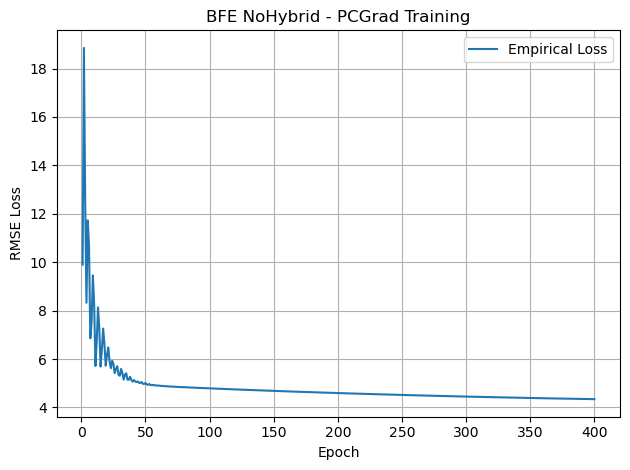

In [34]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        #self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        final_weights = mn.ruleGraphConvLayer.w_s  # capture after training

        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)


# PCGrad optimizer
opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
mn.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_nohyb = np.array(X_train).astype(np.float32)
y_train_nohyb = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_nohyb = []
epochs = 400

for ep in range(epochs):
    epoch_start = time.time()

    with tf.GradientTape() as tape:
        preds = mn(X_train_nohyb, training=True)
        loss = pure_rmse(y_train_nohyb, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, mn.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_nohyb.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    # Displaying Each epoch one by one seems to take up a lot of time
    # Each epoch takes 90s to run, there are 400 so it would finish in 10 hours
    # Unfortunately it also kills the kernel so running at every 10 for now
    if ep % 10 == 0 or ep == epochs - 1:
        print(f"Epoch {ep+1}/{epochs}")
        print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")


# Plot
plt.plot(range(1, epochs + 1), loss_tracker_nohyb, label="Empirical Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE NoHybrid - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = pure_rmse(y_test_nohyb, y_pred_test_nohyb).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))


result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


The mean absolute difference between y_tru & y_pred is : 3.0400562477281357


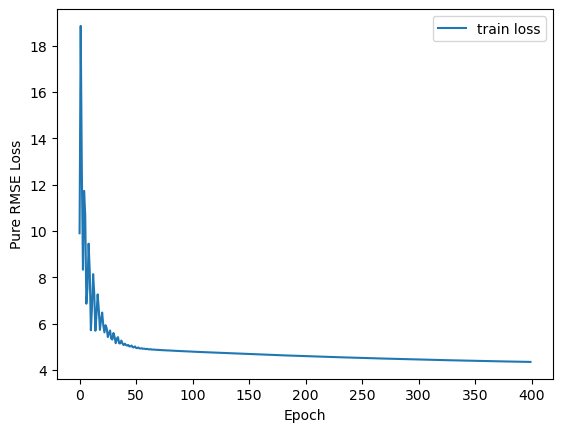

In [36]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_nohyb, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Pure RMSE Loss')
plt.legend()
plt.show()

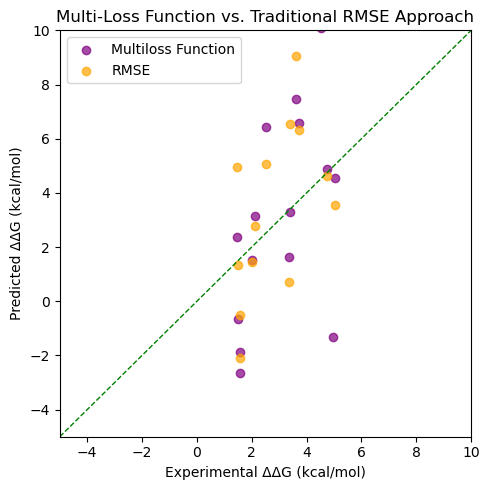

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('DDG_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITH STRUCTURAL

In [38]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [39]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValen

[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[18:43:57] DEPRECATION WARNING: please use GetValen

In [40]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

Inside call


Epoch 1/250
1/1 [==============================] - 20s 20s/step - loss: 9.8987
Inside call


Epoch 2/250
1/1 [==============================] - 1s 1s/step - loss: 14.7291
Inside call


Epoch 3/250
1/1 [==============================] - 1s 1s/step - loss: 8.6459
Inside call


Epoch 4/250
1/1 [==============================] - 1s 1s/step - loss: 8.7625
Inside call


Epoch 5/250
1/1 [==============================] - 1s 1s/step - loss: 10.1991
Inside call


Epoch 6/250
1/1 [==============================] - 1s 1s/step - loss: 6.9067
Inside call


Epoch 7/250
1/1 [==============================] - 1s 1s/step - loss: 5.5447
Inside call


Epoch 8/250
1/1 [==============================] - 1s 1s/step - loss: 7.9039
Inside call


Epoch 9/250
1/1 [==============================] - 1s 1s/step - loss: 7.0856
Inside call


Epoch 10/250
1/1 [==============================] - 1s 1s/step - loss: 4.6093
Inside call


Epoch 11/250
1/1 [==============================] - 1s 1s/step - loss: 5.9267
Inside call


Epoch 12/250
1/1 [==============================] - 1s 1s/step - loss: 7.0051
Inside call


Epoch 13/250
1/1 [==============================] - 1s 1s/step - loss: 5.7200
Inside call


Epoch 14/250
1/1 [==============================] - 1s 1s/step - loss: 4.6043
Inside call


Epoch 15/250
1/1 [==============================] - 1s 1s/step - loss: 5.7936
Inside call


Epoch 16/250
1/1 [==============================] - 1s 1s/step - loss: 5.9267
Inside call


Epoch 17/250
1/1 [==============================] - 1s 1s/step - loss: 4.9065
Inside call


Epoch 18/250
1/1 [==============================] - 1s 1s/step - loss: 4.8757
Inside call


Epoch 19/250
1/1 [==============================] - 1s 1s/step - loss: 5.3388
Inside call


Epoch 20/250
1/1 [==============================] - 1s 1s/step - loss: 4.9581
Inside call


Epoch 21/250
1/1 [==============================] - 1s 1s/step - loss: 4.6787
Inside call


Epoch 22/250
1/1 [==============================] - 1s 1s/step - loss: 4.8959
Inside call


Epoch 23/250
1/1 [==============================] - 1s 1s/step - loss: 4.7000
Inside call


Epoch 24/250
1/1 [==============================] - 1s 1s/step - loss: 4.5215
Inside call


Epoch 25/250
1/1 [==============================] - 1s 1s/step - loss: 4.7699
Inside call


Epoch 26/250
1/1 [==============================] - 1s 1s/step - loss: 4.6043
Inside call


Epoch 27/250
1/1 [==============================] - 1s 1s/step - loss: 4.3109
Inside call


Epoch 28/250
1/1 [==============================] - 1s 1s/step - loss: 4.6079
Inside call


Epoch 29/250
1/1 [==============================] - 1s 1s/step - loss: 4.6161
Inside call


Epoch 30/250
1/1 [==============================] - 1s 1s/step - loss: 4.2360
Inside call


Epoch 31/250
1/1 [==============================] - 1s 1s/step - loss: 4.3727
Inside call


Epoch 32/250
1/1 [==============================] - 1s 1s/step - loss: 4.5275
Inside call


Epoch 33/250
1/1 [==============================] - 1s 1s/step - loss: 4.2507
Inside call


Epoch 34/250
1/1 [==============================] - 1s 1s/step - loss: 4.2244
Inside call


Epoch 35/250
1/1 [==============================] - 1s 1s/step - loss: 4.3594
Inside call


Epoch 36/250
1/1 [==============================] - 1s 1s/step - loss: 4.2376
Inside call


Epoch 37/250
1/1 [==============================] - 1s 1s/step - loss: 4.2010
Inside call


Epoch 38/250
1/1 [==============================] - 1s 1s/step - loss: 4.2280
Inside call


Epoch 39/250
1/1 [==============================] - 1s 1s/step - loss: 4.1853
Inside call


Epoch 40/250
1/1 [==============================] - 1s 1s/step - loss: 4.2136
Inside call


Epoch 41/250
1/1 [==============================] - 1s 1s/step - loss: 4.1607
Inside call


Epoch 42/250
1/1 [==============================] - 1s 1s/step - loss: 4.1262
Inside call


Epoch 43/250
1/1 [==============================] - 1s 1s/step - loss: 4.1981
Inside call


Epoch 44/250
1/1 [==============================] - 1s 1s/step - loss: 4.1211
Inside call


Epoch 45/250
1/1 [==============================] - 1s 1s/step - loss: 4.0865
Inside call


Epoch 46/250
1/1 [==============================] - 1s 1s/step - loss: 4.1549
Inside call


Epoch 47/250
1/1 [==============================] - 1s 1s/step - loss: 4.0901
Inside call


Epoch 48/250
1/1 [==============================] - 1s 1s/step - loss: 4.0731
Inside call


Epoch 49/250
1/1 [==============================] - 1s 1s/step - loss: 4.1066
Inside call


Epoch 50/250
1/1 [==============================] - 1s 1s/step - loss: 4.0710
Inside call


Epoch 51/250
1/1 [==============================] - 1s 1s/step - loss: 4.0716
Inside call


Epoch 52/250
1/1 [==============================] - 1s 1s/step - loss: 4.0654
Inside call


Epoch 53/250
1/1 [==============================] - 1s 1s/step - loss: 4.0623
Inside call


Epoch 54/250
1/1 [==============================] - 1s 1s/step - loss: 4.0616
Inside call


Epoch 55/250
1/1 [==============================] - 1s 1s/step - loss: 4.0355
Inside call


Epoch 56/250
1/1 [==============================] - 1s 1s/step - loss: 4.0542
Inside call


Epoch 57/250
1/1 [==============================] - 1s 1s/step - loss: 4.0398
Inside call


Epoch 58/250
1/1 [==============================] - 1s 1s/step - loss: 4.0212
Inside call


Epoch 59/250
1/1 [==============================] - 1s 1s/step - loss: 4.0401
Inside call


Epoch 60/250
1/1 [==============================] - 1s 1s/step - loss: 4.0196
Inside call


Epoch 61/250
1/1 [==============================] - 1s 1s/step - loss: 4.0173
Inside call


Epoch 62/250
1/1 [==============================] - 1s 1s/step - loss: 4.0203
Inside call


Epoch 63/250
1/1 [==============================] - 1s 1s/step - loss: 4.0102
Inside call


Epoch 64/250
1/1 [==============================] - 1s 1s/step - loss: 4.0093
Inside call


Epoch 65/250
1/1 [==============================] - 1s 1s/step - loss: 4.0026
Inside call


Epoch 66/250
1/1 [==============================] - 1s 1s/step - loss: 4.0044
Inside call


Epoch 67/250
1/1 [==============================] - 1s 1s/step - loss: 3.9940
Inside call


Epoch 68/250
1/1 [==============================] - 1s 1s/step - loss: 3.9930
Inside call


Epoch 69/250
1/1 [==============================] - 1s 1s/step - loss: 3.9927
Inside call


Epoch 70/250
1/1 [==============================] - 1s 1s/step - loss: 3.9817
Inside call


Epoch 71/250
1/1 [==============================] - 1s 1s/step - loss: 3.9853
Inside call


Epoch 72/250
1/1 [==============================] - 1s 1s/step - loss: 3.9786
Inside call


Epoch 73/250
1/1 [==============================] - 1s 1s/step - loss: 3.9751
Inside call


Epoch 74/250
1/1 [==============================] - 1s 1s/step - loss: 3.9731
Inside call


Epoch 75/250
1/1 [==============================] - 1s 1s/step - loss: 3.9689
Inside call


Epoch 76/250
1/1 [==============================] - 1s 1s/step - loss: 3.9656
Inside call


Epoch 77/250
1/1 [==============================] - 1s 1s/step - loss: 3.9616
Inside call


Epoch 78/250
1/1 [==============================] - 1s 1s/step - loss: 3.9600
Inside call


Epoch 79/250
1/1 [==============================] - 1s 1s/step - loss: 3.9537
Inside call


Epoch 80/250
1/1 [==============================] - 1s 1s/step - loss: 3.9532
Inside call


Epoch 81/250
1/1 [==============================] - 1s 1s/step - loss: 3.9484
Inside call


Epoch 82/250
1/1 [==============================] - 1s 1s/step - loss: 3.9450
Inside call


Epoch 83/250
1/1 [==============================] - 1s 1s/step - loss: 3.9429
Inside call


Epoch 84/250
1/1 [==============================] - 1s 1s/step - loss: 3.9386
Inside call


Epoch 85/250
1/1 [==============================] - 1s 1s/step - loss: 3.9360
Inside call


Epoch 86/250
1/1 [==============================] - 1s 1s/step - loss: 3.9326
Inside call


Epoch 87/250
1/1 [==============================] - 1s 1s/step - loss: 3.9296
Inside call


Epoch 88/250
1/1 [==============================] - 2s 2s/step - loss: 3.9258
Inside call


Epoch 89/250
1/1 [==============================] - 1s 1s/step - loss: 3.9237
Inside call


Epoch 90/250
1/1 [==============================] - 1s 1s/step - loss: 3.9195
Inside call


Epoch 91/250
1/1 [==============================] - 1s 1s/step - loss: 3.9172
Inside call


Epoch 92/250
1/1 [==============================] - 1s 1s/step - loss: 3.9138
Inside call


Epoch 93/250
1/1 [==============================] - 1s 1s/step - loss: 3.9106
Inside call


Epoch 94/250
1/1 [==============================] - 1s 1s/step - loss: 3.9078
Inside call


Epoch 95/250
1/1 [==============================] - 1s 1s/step - loss: 3.9046
Inside call


Epoch 96/250
1/1 [==============================] - 1s 1s/step - loss: 3.9016
Inside call


Epoch 97/250
1/1 [==============================] - 1s 1s/step - loss: 3.8987
Inside call


Epoch 98/250
1/1 [==============================] - 1s 1s/step - loss: 3.8955
Inside call


Epoch 99/250
1/1 [==============================] - 1s 1s/step - loss: 3.8925
Inside call


Epoch 100/250
1/1 [==============================] - 1s 1s/step - loss: 3.8897
Inside call


Epoch 101/250
1/1 [==============================] - 1s 1s/step - loss: 3.8864
Inside call


Epoch 102/250
1/1 [==============================] - 1s 1s/step - loss: 3.8838
Inside call


Epoch 103/250
1/1 [==============================] - 1s 1s/step - loss: 3.8806
Inside call


Epoch 104/250
1/1 [==============================] - 1s 1s/step - loss: 3.8778
Inside call


Epoch 105/250
1/1 [==============================] - 1s 1s/step - loss: 3.8748
Inside call


Epoch 106/250
1/1 [==============================] - 1s 1s/step - loss: 3.8719
Inside call


Epoch 107/250
1/1 [==============================] - 1s 1s/step - loss: 3.8690
Inside call


Epoch 108/250
1/1 [==============================] - 1s 1s/step - loss: 3.8662
Inside call


Epoch 109/250
1/1 [==============================] - 1s 1s/step - loss: 3.8632
Inside call


Epoch 110/250
1/1 [==============================] - 1s 1s/step - loss: 3.8605
Inside call


Epoch 111/250
1/1 [==============================] - 1s 1s/step - loss: 3.8575
Inside call


Epoch 112/250
1/1 [==============================] - 1s 1s/step - loss: 3.8547
Inside call


Epoch 113/250
1/1 [==============================] - 1s 1s/step - loss: 3.8519
Inside call


Epoch 114/250
1/1 [==============================] - 1s 1s/step - loss: 3.8491
Inside call


Epoch 115/250
1/1 [==============================] - 1s 1s/step - loss: 3.8462
Inside call


Epoch 116/250
1/1 [==============================] - 1s 1s/step - loss: 3.8434
Inside call


Epoch 117/250
1/1 [==============================] - 1s 1s/step - loss: 3.8406
Inside call


Epoch 118/250
1/1 [==============================] - 1s 1s/step - loss: 3.8379
Inside call


Epoch 119/250
1/1 [==============================] - 1s 1s/step - loss: 3.8350
Inside call


Epoch 120/250
1/1 [==============================] - 1s 1s/step - loss: 3.8323
Inside call


Epoch 121/250
1/1 [==============================] - 1s 1s/step - loss: 3.8295
Inside call


Epoch 122/250
1/1 [==============================] - 1s 1s/step - loss: 3.8268
Inside call


Epoch 123/250
1/1 [==============================] - 1s 1s/step - loss: 3.8241
Inside call


Epoch 124/250
1/1 [==============================] - 1s 1s/step - loss: 3.8214
Inside call


Epoch 125/250
1/1 [==============================] - 1s 1s/step - loss: 3.8187
Inside call


Epoch 126/250
1/1 [==============================] - 1s 1s/step - loss: 3.8160
Inside call


Epoch 127/250
1/1 [==============================] - 1s 1s/step - loss: 3.8133
Inside call


Epoch 128/250
1/1 [==============================] - 1s 1s/step - loss: 3.8106
Inside call


Epoch 129/250
1/1 [==============================] - 1s 1s/step - loss: 3.8079
Inside call


Epoch 130/250
1/1 [==============================] - 1s 1s/step - loss: 3.8053
Inside call


Epoch 131/250
1/1 [==============================] - 1s 1s/step - loss: 3.8026
Inside call


Epoch 132/250
1/1 [==============================] - 1s 1s/step - loss: 3.8000
Inside call


Epoch 133/250
1/1 [==============================] - 1s 1s/step - loss: 3.7973
Inside call


Epoch 134/250
1/1 [==============================] - 1s 1s/step - loss: 3.7947
Inside call


Epoch 135/250
1/1 [==============================] - 1s 1s/step - loss: 3.7921
Inside call


Epoch 136/250
1/1 [==============================] - 1s 1s/step - loss: 3.7895
Inside call


Epoch 137/250
1/1 [==============================] - 1s 1s/step - loss: 3.7869
Inside call


Epoch 138/250
1/1 [==============================] - 2s 2s/step - loss: 3.7843
Inside call


Epoch 139/250
1/1 [==============================] - 1s 1s/step - loss: 3.7818
Inside call


Epoch 140/250
1/1 [==============================] - 1s 1s/step - loss: 3.7792
Inside call


Epoch 141/250
1/1 [==============================] - 1s 1s/step - loss: 3.7767
Inside call


Epoch 142/250
1/1 [==============================] - 1s 1s/step - loss: 3.7741
Inside call


Epoch 143/250
1/1 [==============================] - 1s 1s/step - loss: 3.7716
Inside call


Epoch 144/250
1/1 [==============================] - 1s 1s/step - loss: 3.7691
Inside call


Epoch 145/250
1/1 [==============================] - 1s 1s/step - loss: 3.7666
Inside call


Epoch 146/250
1/1 [==============================] - 1s 1s/step - loss: 3.7641
Inside call


Epoch 147/250
1/1 [==============================] - 1s 1s/step - loss: 3.7616
Inside call


Epoch 148/250
1/1 [==============================] - 1s 1s/step - loss: 3.7591
Inside call


Epoch 149/250
1/1 [==============================] - 1s 1s/step - loss: 3.7567
Inside call


Epoch 150/250
1/1 [==============================] - 1s 1s/step - loss: 3.7542
Inside call


Epoch 151/250
1/1 [==============================] - 1s 1s/step - loss: 3.7518
Inside call


Epoch 152/250
1/1 [==============================] - 1s 1s/step - loss: 3.7494
Inside call


Epoch 153/250
1/1 [==============================] - 1s 1s/step - loss: 3.7469
Inside call


Epoch 154/250
1/1 [==============================] - 1s 1s/step - loss: 3.7445
Inside call


Epoch 155/250
1/1 [==============================] - 1s 1s/step - loss: 3.7421
Inside call


Epoch 156/250
1/1 [==============================] - 1s 1s/step - loss: 3.7397
Inside call


Epoch 157/250
1/1 [==============================] - 1s 1s/step - loss: 3.7374
Inside call


Epoch 158/250
1/1 [==============================] - 1s 1s/step - loss: 3.7350
Inside call


Epoch 159/250
1/1 [==============================] - 1s 1s/step - loss: 3.7326
Inside call


Epoch 160/250
1/1 [==============================] - 1s 1s/step - loss: 3.7303
Inside call


Epoch 161/250
1/1 [==============================] - 1s 1s/step - loss: 3.7279
Inside call


Epoch 162/250
1/1 [==============================] - 1s 1s/step - loss: 3.7256
Inside call


Epoch 163/250
1/1 [==============================] - 1s 1s/step - loss: 3.7233
Inside call


Epoch 164/250
1/1 [==============================] - 1s 1s/step - loss: 3.7210
Inside call


Epoch 165/250
1/1 [==============================] - 1s 1s/step - loss: 3.7187
Inside call


Epoch 166/250
1/1 [==============================] - 1s 1s/step - loss: 3.7164
Inside call


Epoch 167/250
1/1 [==============================] - 1s 1s/step - loss: 3.7141
Inside call


Epoch 168/250
1/1 [==============================] - 1s 1s/step - loss: 3.7118
Inside call


Epoch 169/250
1/1 [==============================] - 1s 1s/step - loss: 3.7096
Inside call


Epoch 170/250
1/1 [==============================] - 1s 1s/step - loss: 3.7073
Inside call


Epoch 171/250
1/1 [==============================] - 1s 1s/step - loss: 3.7051
Inside call


Epoch 172/250
1/1 [==============================] - 1s 1s/step - loss: 3.7029
Inside call


Epoch 173/250
1/1 [==============================] - 1s 1s/step - loss: 3.7007
Inside call


Epoch 174/250
1/1 [==============================] - 1s 1s/step - loss: 3.6985
Inside call


Epoch 175/250
1/1 [==============================] - 1s 1s/step - loss: 3.6963
Inside call


Epoch 176/250
1/1 [==============================] - 1s 1s/step - loss: 3.6941
Inside call


Epoch 177/250
1/1 [==============================] - 1s 1s/step - loss: 3.6919
Inside call


Epoch 178/250
1/1 [==============================] - 1s 1s/step - loss: 3.6897
Inside call


Epoch 179/250
1/1 [==============================] - 1s 1s/step - loss: 3.6876
Inside call


Epoch 180/250
1/1 [==============================] - 1s 1s/step - loss: 3.6855
Inside call


Epoch 181/250
1/1 [==============================] - 1s 1s/step - loss: 3.6833
Inside call


Epoch 182/250
1/1 [==============================] - 1s 1s/step - loss: 3.6812
Inside call


Epoch 183/250
1/1 [==============================] - 1s 1s/step - loss: 3.6791
Inside call


Epoch 184/250
1/1 [==============================] - 1s 1s/step - loss: 3.6769
Inside call


Epoch 185/250
1/1 [==============================] - 1s 1s/step - loss: 3.6749
Inside call


Epoch 186/250
1/1 [==============================] - 1s 1s/step - loss: 3.6728
Inside call


Epoch 187/250
1/1 [==============================] - 1s 1s/step - loss: 3.6707
Inside call


Epoch 188/250
1/1 [==============================] - 1s 1s/step - loss: 3.6686
Inside call


Epoch 189/250
1/1 [==============================] - 1s 1s/step - loss: 3.6666
Inside call


Epoch 190/250
1/1 [==============================] - 1s 1s/step - loss: 3.6645
Inside call


Epoch 191/250
1/1 [==============================] - 1s 1s/step - loss: 3.6625
Inside call


Epoch 192/250
1/1 [==============================] - 1s 1s/step - loss: 3.6605
Inside call


Epoch 193/250
1/1 [==============================] - 1s 1s/step - loss: 3.6585
Inside call


Epoch 194/250
1/1 [==============================] - 1s 1s/step - loss: 3.6565
Inside call


Epoch 195/250
1/1 [==============================] - 1s 1s/step - loss: 3.6545
Inside call


Epoch 196/250
1/1 [==============================] - 1s 1s/step - loss: 3.6525
Inside call


Epoch 197/250
1/1 [==============================] - 1s 1s/step - loss: 3.6505
Inside call


Epoch 198/250
1/1 [==============================] - 1s 1s/step - loss: 3.6486
Inside call


Epoch 199/250
1/1 [==============================] - 1s 1s/step - loss: 3.6466
Inside call


Epoch 200/250
1/1 [==============================] - 1s 1s/step - loss: 3.6446
Inside call


Epoch 201/250
1/1 [==============================] - 1s 1s/step - loss: 3.6427
Inside call


Epoch 202/250
1/1 [==============================] - 2s 2s/step - loss: 3.6408
Inside call


Epoch 203/250
1/1 [==============================] - 1s 1s/step - loss: 3.6389
Inside call


Epoch 204/250
1/1 [==============================] - 1s 1s/step - loss: 3.6370
Inside call


Epoch 205/250
1/1 [==============================] - 1s 1s/step - loss: 3.6351
Inside call


Epoch 206/250
1/1 [==============================] - 1s 1s/step - loss: 3.6332
Inside call


Epoch 207/250
1/1 [==============================] - 1s 1s/step - loss: 3.6313
Inside call


Epoch 208/250
1/1 [==============================] - 1s 1s/step - loss: 3.6294
Inside call


Epoch 209/250
1/1 [==============================] - 1s 1s/step - loss: 3.6276
Inside call


Epoch 210/250
1/1 [==============================] - 1s 1s/step - loss: 3.6257
Inside call


Epoch 211/250
1/1 [==============================] - 1s 1s/step - loss: 3.6239
Inside call


Epoch 212/250
1/1 [==============================] - 1s 1s/step - loss: 3.6221
Inside call


Epoch 213/250
1/1 [==============================] - 1s 1s/step - loss: 3.6203
Inside call


Epoch 214/250
1/1 [==============================] - 1s 1s/step - loss: 3.6184
Inside call


Epoch 215/250
1/1 [==============================] - 1s 1s/step - loss: 3.6166
Inside call


Epoch 216/250
1/1 [==============================] - 1s 1s/step - loss: 3.6148
Inside call


Epoch 217/250
1/1 [==============================] - 1s 1s/step - loss: 3.6131
Inside call


Epoch 218/250
1/1 [==============================] - 1s 1s/step - loss: 3.6113
Inside call


Epoch 219/250
1/1 [==============================] - 1s 1s/step - loss: 3.6095
Inside call


Epoch 220/250
1/1 [==============================] - 1s 1s/step - loss: 3.6077
Inside call


Epoch 221/250
1/1 [==============================] - 1s 1s/step - loss: 3.6061
Inside call


Epoch 222/250
1/1 [==============================] - 1s 1s/step - loss: 3.6043
Inside call


Epoch 223/250
1/1 [==============================] - 1s 1s/step - loss: 3.6026
Inside call


Epoch 224/250
1/1 [==============================] - 1s 1s/step - loss: 3.6009
Inside call


Epoch 225/250
1/1 [==============================] - 1s 1s/step - loss: 3.5992
Inside call


Epoch 226/250
1/1 [==============================] - 1s 1s/step - loss: 3.5974
Inside call


Epoch 227/250
1/1 [==============================] - 1s 1s/step - loss: 3.5958
Inside call


Epoch 228/250
1/1 [==============================] - 1s 1s/step - loss: 3.5941
Inside call


Epoch 229/250
1/1 [==============================] - 1s 1s/step - loss: 3.5924
Inside call


Epoch 230/250
1/1 [==============================] - 1s 1s/step - loss: 3.5908
Inside call


Epoch 231/250
1/1 [==============================] - 1s 1s/step - loss: 3.5891
Inside call


Epoch 232/250
1/1 [==============================] - 1s 1s/step - loss: 3.5875
Inside call


Epoch 233/250
1/1 [==============================] - 1s 1s/step - loss: 3.5858
Inside call


Epoch 234/250
1/1 [==============================] - 1s 1s/step - loss: 3.5842
Inside call


Epoch 235/250
1/1 [==============================] - 1s 1s/step - loss: 3.5826
Inside call


Epoch 236/250
1/1 [==============================] - 1s 1s/step - loss: 3.5810
Inside call


Epoch 237/250
1/1 [==============================] - 1s 1s/step - loss: 3.5794
Inside call


Epoch 238/250
1/1 [==============================] - 1s 1s/step - loss: 3.5778
Inside call


Epoch 239/250
1/1 [==============================] - 1s 1s/step - loss: 3.5762
Inside call


Epoch 240/250
1/1 [==============================] - 1s 1s/step - loss: 3.5747
Inside call


Epoch 241/250
1/1 [==============================] - 1s 1s/step - loss: 3.5731
Inside call


Epoch 242/250
1/1 [==============================] - 1s 1s/step - loss: 3.5715
Inside call


Epoch 243/250
1/1 [==============================] - 1s 1s/step - loss: 3.5700
Inside call


Epoch 244/250
1/1 [==============================] - 1s 1s/step - loss: 3.5685
Inside call


Epoch 245/250
1/1 [==============================] - 1s 1s/step - loss: 3.5670
Inside call


Epoch 246/250
1/1 [==============================] - 1s 1s/step - loss: 3.5654
Inside call


Epoch 247/250
1/1 [==============================] - 1s 1s/step - loss: 3.5639
Inside call


Epoch 248/250
1/1 [==============================] - 1s 1s/step - loss: 3.5624
Inside call


Epoch 249/250
1/1 [==============================] - 1s 1s/step - loss: 3.5609
Inside call


Epoch 250/250
1/1 [==============================] - 1s 1s/step - loss: 3.5594


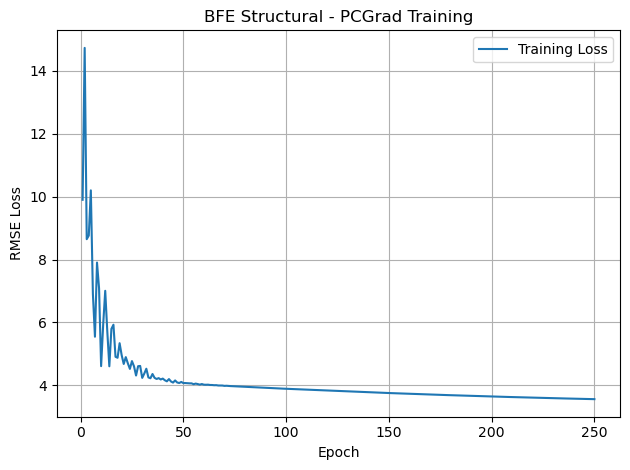

In [41]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
    
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms = PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)

opt = PCGrad(tf.keras.optimizers.Adam(learning_rate=0.005))

# Preprocess input
input_shapes = [x.shape[0] for x in X_train]
ms.set_input_shapes(input_shapes)

for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        padding = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], padding], axis=0)

X_train_struct = np.array(X_train).astype(np.float32)
y_train_struct = np.array(y_train).astype(np.float32)

# Loss tracking
loss_tracker_struct = []

# Manual training loop
epochs = 250
for ep in range(epochs):
    epoch_start = time.time()
    with tf.GradientTape() as tape:
        preds = ms(X_train_struct, training=True)
        loss = pure_rmse(y_train_struct, preds)

    grads_and_vars = opt.compute_gradients([loss], tape, ms.trainable_variables)
    opt.apply_gradients(grads_and_vars)

    loss_val = float(loss.numpy())
    loss_tracker_struct.append(loss_val)

    epoch_end = time.time()
    duration = epoch_end - epoch_start
    duration_str = f"{duration:.0f}s" if duration > 1 else f"{duration*1000:.0f}ms"

    print(f"Epoch {ep+1}/{epochs}")
    print(f"1/1 [==============================] - {duration_str} {duration_str}/step - loss: {loss_val:.4f}")

plt.plot(range(1, epochs + 1), loss_tracker_struct, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE Loss")
plt.title("BFE Structural - PCGrad Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

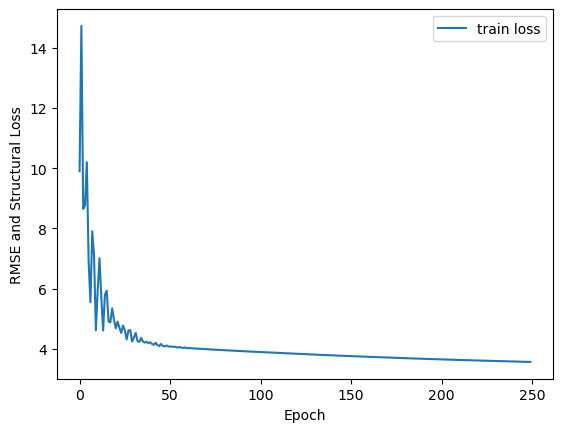

In [42]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(loss_tracker_struct, label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [43]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 53])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
#eval_struct = ms.evaluate(X_test_struct, y_test_struct)
eval_struct = pure_rmse(y_test_struct, y_pred_test_struct).numpy()
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)

Inside call


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


The mean absolute difference between y_tru & y_pred is : 2.458481773079766


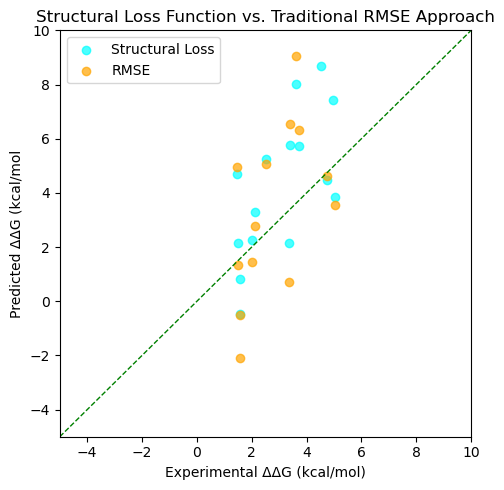

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line

plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

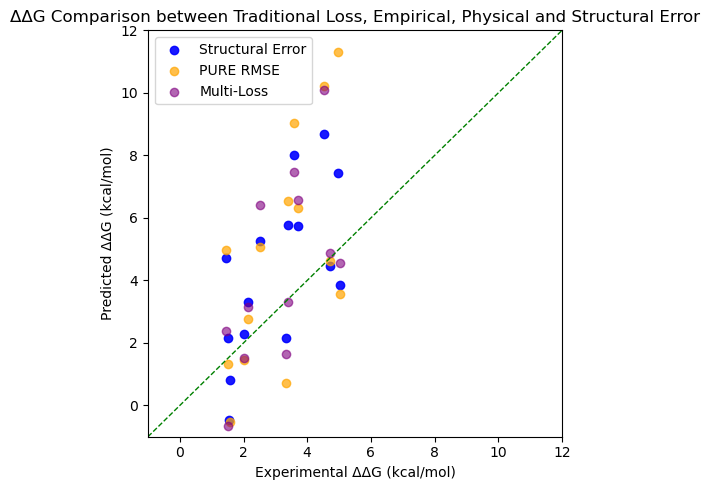

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔΔG Comparison between Traditional Loss, Empirical, Physical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [46]:
# Save individual run results
individual_filename = f'/home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")

Results saved to /home/lvarga57/multiloss-bfe/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl
